<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">
</p>
<p style="margin: 0; text-align:right;">2023-2 · Máster universitario en Ciencia de datos (Data science)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudios de Informática, Multimedia y Telecomunicación</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>


# TFM: Dermatological lesion Classificator

The ISIC Challenge 2019 dataset is used in this paper to build a robust skin lesion classifier. It consists of a set of 25,331 dermoscopic images related to 8 different types of skin diseases.

https://challenge.isic-archive.com/data/#2019



# 1 - Library used in this work

In [1]:
# Loading library needed in this job.
import os
import pandas as pd
import numpy as np
import random
import shutil
import scipy
import time
import matplotlib.pyplot as plt
import _pickle as pickle
import cv2
from google.colab.patches import cv2_imshow
from sklearn.metrics import roc_curve
import nbconvert

import tensorflow as tf
from keras import layers
from keras.layers import BatchNormalization
from keras.utils import to_categorical
from tqdm.keras import TqdmCallback
from keras.callbacks import EarlyStopping
from keras.models import save_model, load_model
from keras.preprocessing.image import ImageDataGenerator, array_to_img
from keras.applications.resnet_v2 import ResNet50V2

from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.metrics import F1Score
from tensorflow.python.keras.utils.layer_utils import count_params
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, f1_score, precision_score, recall_score, accuracy_score

from tqdm.keras import TqdmCallback

from imblearn.over_sampling import SMOTE

In [2]:
# Testing GRU info
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  !nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-44747c9d-ebc5-02cb-a8aa-030cb3c2fcb5)


Path list used in this job. It must be modified if the Jupiter notebook captures the files from other folders.

In [2]:
# Base path with project folders
base_path = '/content/drive/MyDrive/Colab Notebooks/Master UOC/TFM/Dermatological lesion classification/Data/'
metrics_path = '/content/drive/MyDrive/Colab Notebooks/Master UOC/TFM/Dermatological lesion classification/Data/Metrics'

# Original dataset
images_path_train2 = '/content/drive/MyDrive/Colab Notebooks/Master UOC/TFM/Dermatological lesion classification/Data/Train2'
images_path_val = '/content/drive/MyDrive/Colab Notebooks/Master UOC/TFM/Dermatological lesion classification/Data/Valid'
images_path_test2 = '/content/drive/MyDrive/Colab Notebooks/Master UOC/TFM/Dermatological lesion classification/Data/Test2'

# Train, validation and test dataset. It is structurates to run with keras flow_from_directory pipeline
images_train_path = '/content/drive/MyDrive/Colab Notebooks/Master UOC/TFM/Dermatological lesion classification/Data/Train3'
images_valid_path = '/content/drive/MyDrive/Colab Notebooks/Master UOC/TFM/Dermatological lesion classification/Data/Valid3'
images_test_path = '/content/drive/MyDrive/Colab Notebooks/Master UOC/TFM/Dermatological lesion classification/Data/Test3'

# Isic2019 csv file. It associates the image file name with its label.
ground_truth_file = 'ISIC_2019_Training_GroundTruth.csv'

#train_path = '/content/drive/MyDrive/Colab Notebooks/Master UOC/TFM/Dermatological lesion classification/Data/Train3'

# 2 - Framework definition

This chapter defines the functions we need to do the job. It is divided into three parts:
- **General Functions**: General Purpose Functions
- **Data Augmentation**: Section where the data augmentation process is configured and an example of its operation with a subset of data is made.
- **Network Model Definition**: We will define the procedure that defines the classification layer that is common to all models.

## 2.1 General functions

In [3]:
def load_csv_to_df(file_name):
    '''
    file upload from disk.
    Input:
        - file_name: File name with extension file.
    Output:
        - A Pandas dataframe or a call to create a new dataframe
    '''
    try:
        df =  pd.read_csv(file_name, encoding='utf-8', index_col=0)
        return(df)
    except FileNotFoundError:
        print('No File was found')
        return(df)

In [4]:
def return_label_from_image(images_list_df, picture_name):
    '''
    Looking for the picture label. The class is codify with a integer number.
    case stament has been introduce on 3.10 python version, but we don't use
    for compatibility reason.
    Input:
        images_list_df: Ground Truth dataframe
        picture_name: Picture filename
    Output:
        The label corresponding to the file name
    '''
    # Has picture_name the jpg extension?
    if picture_name.split('.')[-1] == 'jpg':
        picture_name = picture_name.split('.')[0]

    rec = images_list_df.loc[picture_name]

    label = ''
    if rec['MEL'] == 1:
        label = 'MEL'
    elif rec['NV'] == 1:
        label = 'NV'
    elif rec['BCC'] == 1:
        label = 'BCC'
    elif rec['AK'] == 1:
        label = 'AK'
    elif rec['BKL'] == 1:
        label = 'BKL'
    elif rec['DF'] == 1:
        label = 'DF'
    elif rec['VASC'] == 1:
        label = 'VASC'
    elif rec['SCC'] == 1:
        label = 'SCC'
    else:
        label = 'Unknow'

    return (label)


In [5]:
def return_label_from_index(idx):
    '''
    Looking for the picture label from index.
    Makes a direct translation from full label format to short label format
    Input:
        idx: index
    Output:
        The short label corresponding to the index
    '''
    name = ''
    if idx == 0:
        name = 'MEL'
    elif idx == 1:
        name = 'NV'
    elif idx == 2:
        name = 'BCC'
    elif idx == 3:
        name = 'AK'
    elif idx == 4:
        name = 'BKL'
    elif idx == 5:
        name = 'DF'
    elif idx == 6:
        name = 'VASC'
    elif idx == 7:
        name = 'SCC'
    else:
        name = 'Unknow'
    return(name)

In [6]:
def return_skin_name_from_label(label):
    '''
    This function performs the translation from short label to long label.
    Input: Short label
    Output: Long label
    '''
    name = ''
    if label == 'MEL':
        name = 'Melanoma'
    elif label == 'NV':
        name = 'Melanocytic nevus'
    elif label == 'BCC':
        name = 'Basal cell carcinoma'
    elif label == 'AK':
        name = 'Actinic keratosis'
    elif label == 'BKL':
        name = 'Benign keratosis'
    elif label == 'DF':
        name = 'Dermatofibroma'
    elif label == 'VASC':
        name = 'Vascular lesion'
    elif label == 'SCC':
        name = 'Squamous cell carcinoma'
    else:
        name = 'Unknow'
    return(name)

In [7]:
def y_label_build(images_list_df, picture_list):
    '''
    Given a list formed with the names of the files, it obtains its label in another output list.
    Input:
        image_list_df: Ground Truth dataframe
        picture_list: filenames list

    Output:
        Shortlabel list
    '''

    label_list = []

    # Making the label list
    for p in picture_list:
        label_list.append(return_label_from_image(images_list_df, p))

    return (label_list)

In [8]:
def show_training_layers(model):
    '''
    Show the model layers with the trainable feature.
    Input:
        - model: A model to see the layers
    Output:
        - df: A pandas dataframe with the model layers
    '''

    comp_columns = ['#Layer', 'LayerName', 'Trainable', 'Type']
    df = pd.DataFrame(columns = comp_columns)

    for lnum, layer in enumerate(model.layers):
        df = pd.concat([df, pd.DataFrame([[lnum, layer.name, str(layer.trainable), layer.dtype]], columns=comp_columns)])

    df.reset_index(drop=True, inplace=True)

    return (df)

In [9]:
# Plot del training loss and accury Scores

def plot_prediction(history, save_picture=False, metric='accuracy', title='model accuray-loss', folder = ''):
    '''
    Draws the prediction from the data collected during model training.
    Input:
        history: History model
        save_picture: This parameter indicates if the result will be save. Boolean value with false by default.
        metric: The metric used to evaluate the model during the training.
        title: Chart title
        folder: Not used.
    '''
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))
    # Visualizamos la evolución del F1 score
    ax1.plot(history.history[metric])
    ax1.plot(history.history['val_'+ metric])
    ax1.title.set_text(f'model {metric} score')
    ax1.set_ylabel(f'{metric} score')
    ax1.set_xlabel('epoch')
    ax1.legend(['train', 'Validation'], loc='lower right')

    # Visualizamos la evolución del error cometido por la red
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.title.set_text('model loss')
    ax2.set_ylabel('loss')
    ax2.set_xlabel('epoch')
    ax2.legend(['train', 'Validation'], loc='upper right')

    plt.suptitle(title)
    if save_picture == True:
        file_name = title +'.png'
        plt.savefig(os.path.join(metrics_path, file_name), dpi=300)
        print(f'Picture {file_name} saved to disc')
    plt.show()

In [10]:
def metrics_calculation(y_test, y_pred, labels, model_name, end_time):
    '''
    Compose the model metrics dictionary
    Input:
        y_test: The testing labels
        y_pred: The model prediction labels
        labels: The short label name.
        model_name: model name.
        end_time: Training time duration.
    Output:
        metrics_dict: A dictionary with the metrics of the model.
    '''

    # Compose the metrics dictionary
    metrics_dict = dict()
    # Metric by class
    metrics_dict['f1_vec'] = (f1_score(y_test,  y_pred, average=None))
    metrics_dict['prec_vec'] = (precision_score(y_test,  y_pred, average=None))
    metrics_dict['recall_vec'] = (recall_score(y_test,  y_pred, average=None))

    # Global model metrics
    metrics_dict['f1'] = (f1_score(y_test,  y_pred, average='macro'))
    metrics_dict['acc'] = (accuracy_score(y_test,  y_pred))
    metrics_dict['prec'] = precision_score(y_test,  y_pred, average='macro')
    metrics_dict['recall'] = recall_score(y_test,  y_pred, average='macro')

    # Metadata
    metrics_dict['labels'] = labels
    metrics_dict['model_name'] = model_name
    metrics_dict['Time'] = end_time

    # Roc curve parameters
    #metrics_dict['roc'] = roc_parameters

    return(metrics_dict)

In [11]:
def printer_metrics(metrics_dict):
    '''
    From the model metric dictionary, print the result for screen.
    Input:
        metrics_dict: The model dictionary with the metrics of the training process.
    '''

    model_result = pd.DataFrame([
        metrics_dict['prec_vec'],
        metrics_dict['recall_vec'],
        metrics_dict['f1_vec']
        ],
        index = ['precision', 'sensibity', 'f1 score'],
                                columns=metrics_dict['labels'])
    print(model_result)
    print()
    print(f'Model Accuracy: {metrics_dict["acc"]}')
    print(f'Model f1 score: {round(metrics_dict["f1"],2)}')
    print(f'Model Precision: {round(metrics_dict["prec"],2)}')
    print(f'Model Sensibity: {round(metrics_dict["recall"],2)}')

In [12]:
def load_dict_from_disc(filename):
    try:
        with open(filename, 'rb') as f:
            loaded_dict = pickle.load(f)
    except Exception as err:
        print(f'Not possible to read the file {filename}')
        print(err)
    return(loaded_dict)

In [13]:
def save_dict_to_disc(dict, filename):
    '''
    Function for saving a dict into disc
    Input:
        dict: The dictionary to be saved.
        filename: The output filename.
    Output:
        none or message error if the process is not finished correctly.
    '''
    try:
        with open(filename + '.pkl', 'wb') as f:
            pickle.dump(dict, f)
    except Exception as err:
        print(f'Not possible to write the file {filename}')
        print(err)

In [14]:
def results_model_management(model, model_history, valid_generator, test_generator, end_time):
    '''
    The process model evaluation.
    Input:
        model: A Keras model.
        model_history: The training history of the model.
        valid_generator: Validation dataset of image generator.
        test_generator: Test dataset of image generator.
        end_time: Time spend during the training process.


    '''
    # Variables and const.
    model_name = model.name
    name_model_file = os.path.join('./models/' + model_name + '.h5')

    # Epoch number are run
    n_epoch = len(model_history.history['loss'])

    # Plot the F1 score and loss graph
    plot_prediction(model_history, True, 'accuracy', model_name + '_model accuray-loss', metrics_path)


    # Model evaluation
    print('>> Model evaluation')
    #scores = model.evaluate(X_test, y_test, verbose=0)
    scores = model.evaluate(valid_generator, verbose=1)

    print('Loss: %.3f' % scores[0])
    print('Accuracy: %.3f' % scores[1])

    # Prediction
    print('>> Model prediction')
    y_pred_by_class = model.predict(test_generator)
    y_pred = [np.argmax(p) for p in y_pred_by_class]

    # Roc curve parameters
    #fpr, tpr, thresholds = roc_curve(test_generator, y_pred)

    # Label transformation of test & prediction
    labels =list(test_generator.class_indices.keys())
    y_test = [labels[i] for i in test_generator.classes]
    y_pred = [labels[i] for i in y_pred]
    print()

    # Confusion matrix calculation
    print('>> Metrics calculation')
    disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap=plt.cm.Blues)
    fig_name = model_name + ' Confusion matrix'
    plt.title(fig_name, pad=20)
    plt.tight_layout()
    plt.show()
    plt.savefig(os.path.join(metrics_path, fig_name + '.png'))

    # Show the indicators
    metrics_dict = metrics_calculation(y_test, y_pred, labels, model_name, end_time)
    #metrics_dict = metrics_calculation(y_test, y_pred, labels, model_name, end_time, [fpr, tpr, thresholds])
    printer_metrics(metrics_dict)

    # Save metrics to disc
    save_dict_to_disc(metrics_dict, os.path.join(metrics_path, model_name + '_metrics'))


## 2.2 Data Augmentation

With the data augmentation
technique, we generate a series of derived images from an original one. We have applied to
them shifts, rotations, zooms, splits or changes in brightness or colour saturation to obtain new
pictures.

### 2.2.1 Data Augmentation example

Using a random image from the image set, the same transformations used during training are applied to it.

/content/drive/MyDrive/Colab Notebooks/Master UOC/TFM/Dermatological lesion classification/Data/Train2/MEL/ISIC_0073102.jpg


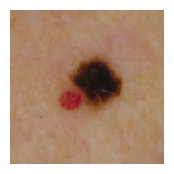

In [16]:
# Original image
filename = 'ISIC_0073102.jpg'
image = os.path.join(images_path_train2, 'MEL', filename)
print(image)

# Creating a dataset which contains just one image.
fig, ax = plt.subplots(figsize=(2, 2))
img = cv2.imread(image, cv2.IMREAD_UNCHANGED)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # OpenCV works in BGR (crazy!)
ax.imshow(img, )
ax.axis('off')
plt.show()

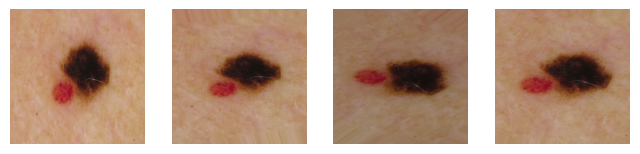

In [17]:
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

# Load the image from disk
img = load_img(image)

# Convert the image to a NumPy array
img_array = img_to_array(img)

# Reshape the array to a single sample with one channel (grayscale)
img_array = img_array.reshape((1,) + img_array.shape)

# Create an ImageDataGenerator instance for data augmentation
datagen = ImageDataGenerator(
    # Specify the desired transformations
    rotation_range=40,
    zoom_range=0.45,
    brightness_range=[0.8, 1.2]
)

# Generate augmented images

i = 0

fig, rows = plt.subplots(nrows=1, ncols=4, figsize=(8,16))
for batch in datagen.flow(img_array, batch_size=1):
    augmented_image = batch[0].astype('uint8')
    rows[i].imshow(augmented_image)
    rows[i].axis('off')
    i += 1
    if i >= 4:  # Display four augmented images
           break

### 2.2.2  Data Augmentation Generator

In [18]:
# Image Data Generation

def image_generator(train_path, val_path, test_path, target_size, batch_size, color_mode, seed, augmentation=False, scale=0):
    '''
    Image generator function. It is called by the training process to generate the training, validation and test image set.
    Input:
        train_path: The train path of images.
        val_path: The validation path of images.
        test_path: The test path of images.
        target_size: Tupla with the output size of images. Ex: (224, 224)
        batch_size: Integer value. The batch size of the training, validation and test process.
        color_mode: Indicates the color format of the pictures. Ex. rgb
        seed: It is used to initialize the random number generator.Fixing to do the same results if the process is repeated.
        augmentation: Boolean parameter with false by default. It indicates if the process use agmentation or not.
        scale: This parameter is used to normalize the image. Three options are possible:
            0: The numpy matrix is not normalized.
            1: The numpy matrix is normalized in the range [0, 1].
            2: The numpy matrix is normalized in the range [-1, 1].

    Output:
        The train, test and validation image generator.
    '''


    print('Generating pictures')

    # Defining the rescale parameter
    if scale == 0:
        rescale = None
    elif scale == 1: # rescale to [0, 1]
        rescale = 1/255.0
    elif scale == 2: # rescale to [-1, 1]
        rescale = 2/255.0,
        featurewise_center = True
        samplewise_center = True
    else:
        raise "Scale error. Possible value: 0, 1, 2"

    if augmentation == True:
        train_datagen = ImageDataGenerator(
            rescale=rescale,
            rotation_range=30,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.45,
            horizontal_flip=True,
            brightness_range=[0.8, 1.2],
            fill_mode='nearest')
    else:
        train_datagen = ImageDataGenerator(
            rescale=rescale
            )

    val_datagen = ImageDataGenerator(rescale=rescale)
    test_datagen = ImageDataGenerator(rescale=rescale)

    train_generator = train_datagen.flow_from_directory(
        directory = train_path,
        target_size = target_size,
        color_mode = color_mode,
        batch_size = batch_size,
        class_mode = 'categorical',
        shuffle = True,
        seed = seed)

    valid_generator = test_datagen.flow_from_directory(
        directory = val_path,
        target_size = target_size,
        color_mode = color_mode,
        batch_size = batch_size,
        class_mode = 'categorical',
        shuffle = False,
        seed = seed)

    test_generator = test_datagen.flow_from_directory(
        directory = test_path,
        target_size = target_size,
        color_mode = color_mode,
        batch_size = 1,
        class_mode = None,
        shuffle = False,
        seed = seed)

    return(train_generator,
           valid_generator,
           test_generator)



## 2.3 Network model definition

In [19]:
def build_model(base_model, num_classes, shape, model_name, seed):

    '''
        Model construction based on a base model as a feature extractor.
        A GlobalAveragePolling2D layer, a BatchNormalization layer,
        a dropout layer which is set with 20% of probability
        and finally, a fully connected layer.
        Input:
             - base_model: The base model used like feature extractor.
             - num_classes: The output number of classes.
             - shape: The input shape.
             - model_name: The model name
             - seed: It is used to initialize the random number generator.Fixing to do the same results if the process is repeated.
        Output:
             - Model: The ensambled model
    '''
    top_dropout_rate = 0.2

    # For reproducible porpose
    tf.random.set_seed(seed)

    inputs = layers.Input(shape=shape, name='input_layer')
    x = base_model(inputs, training=False) # base model is running in inference mode.

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(x)
    x = layers.BatchNormalization()(x)

    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)

    # Ouput layer
    # Multicategory classification
    outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name=model_name)

    return model

In [20]:
def trainingTheModel(model, train_path, val_path, test_path, type_optimizer, target_size, color_mode, learning_rate, batch_size, epochs, augmentation, scale, patience, seed):
    '''
    Training framework.
    Input:
        model: The model ensambled with the FE + Classification layers
        train_path: The picture train path.
        val_path: The picture validation path.
        test_path: The picture test path
        type_optimizer: 2 options are possible, adam or SGD. String parameter.
        target_size: Target size using during the picture transformation. Tuple: (width, long)
        color_mode: String parameter using to define the color codification. Ex. rgb.
        learning_rate: Float paramenter. Learning rate using during the training process.
        batch_size: Size of the batch using during the training process.
        epochs: Training Epochs number.
        augmentation: Boolean parameter. It indicates if the training uses the augmentation process.
        scale: Type of scale to apply to the numpy matrix. Three values are possible:
            0: The numpy matrix is not normalized.
            1: The numpy matrix is normalized in the range [0, 1].
            2: The numpy matrix is normalized in the range [-1, 1].
        patience: Patience number using during Early stopper.
        seed: It is used to initialize the random number generator.Fixing to do the same results if the process is repeated.
    '''
    if type_optimizer == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif type_optimizer == 'SGD':
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    else:
        raise 'Optimizer is not defined.'

    # Model compilation
    model.compile(
        optimizer=optimizer,
        loss="categorical_crossentropy",
        metrics=['accuracy']
    )

    # Data augmentation config
    train_generator, valid_generator, test_generator = image_generator(
        train_path=train_path,
        val_path=val_path,
        test_path=test_path,
        target_size=target_size,
        batch_size=batch_size,
        color_mode=color_mode,
        scale=scale,
        augmentation = augmentation,
        seed=seed)

    STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
    STEP_SIZE_VALID = valid_generator.n // valid_generator.batch_size
    STEP_SIZE_TEST = test_generator.n // test_generator.batch_size

    print(f'Train Step size: {STEP_SIZE_TRAIN}')
    print(f'Validation Step size: {STEP_SIZE_VALID}')
    print(f'Test Step size: {STEP_SIZE_TEST}')

    # Callback definition:
    es = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = patience)

    # Training the model
    print(f'Training the model: {model.name}. Process Start')
    print('----------------------')
    start_time = time.time()

    model_history = model.fit(
        train_generator,
        steps_per_epoch=STEP_SIZE_TRAIN,
        validation_data=valid_generator,
        validation_steps=STEP_SIZE_VALID,
        epochs=epochs,
        callbacks=[es, TqdmCallback(verbose=1)]
        )

    end_time = time.time() - start_time

    print('Training Process finished')
    print('-------------------------')
    print(f'Time Execution: {end_time} sec.')

    return(model, model_history, valid_generator, test_generator, end_time)

In [21]:
def saveModelParameters(model_path, model, model_history):
    # Save the model, weights & history to disc
    '''
    Save the model, weights & history to disc
    Input:
        model_path: The path with folder where the results will be save.
        model: The model used during the training process.
        model_history: The history output of the training process.
    Output:
        The result of the process is showed for sceen
    '''
    try:
        model.save(os.path.join(model_path,  model.name), save_format='h5')
        model.save_weights(os.path.join(model_path, model.name + '_weights.h5'))
        save_dict_to_disc(model_history.history, os.path.join(model_path, model.name + '_history') )
        print(f'Model parameters have been saved.')
        print(os.path.join(model_path, model.name))
    except Exception as err:
        print(f'{err}')


# 3 - Exploratory analysis

This chapter is divided into three parts:
- First, an example of an image for each class of skin disease is shown.
- Second, we study the structure of the dataset used and the problems that arise from unbalanced classes.
- In the third part, the training dataset is constructed and the unbalanced classes are regularized.

##   3.1 Skin lesion sample

[]

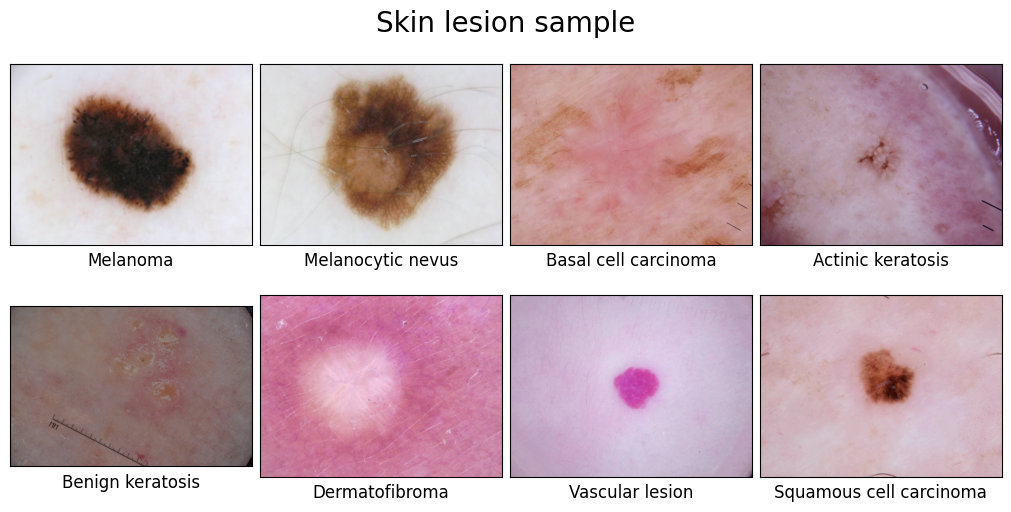

In [21]:
# Skin lesion sample

images_list_df = load_csv_to_df(os.path.join(base_path, ground_truth_file))

labels = images_list_df.columns.to_list()
labels = labels[0:-1]
#print(f'Classes: {labels}') # Verbose
n_index = 2 # Used for selecting the position of the picture name
row = 0
col = 0
n = 0
#images_list = list()

# Plotting the pictures
fig, ax = plt.subplots(2, 4, figsize=(10,5), layout='constrained')
fig.suptitle('Skin lesion sample', fontsize=20)

for l in labels:
    pictureName = images_list_df.index[images_list_df[l] == True][n_index] + '.jpg'
    #print(pictureName) # Verbose

    plt.rcParams['axes.titley'] = 1.0    # y is in axes-relative coordinates.
    plt.rcParams['axes.titlepad'] = -14  # pad is in points...

    img = cv2.imread(os.path.join(images_path_train2, l, pictureName), cv2.IMREAD_UNCHANGED)
    img2 = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # OpenCV works in BGR (crazy!)
    ax[row][col].imshow(img2)
    ax[row][col].set_title(return_skin_name_from_label(l), y=-0.01) # Skin lesion name
    ax[row][col].set(xticks = [], yticks = [])
    if n == 3:
        row += 1
        col = 0
    else:
        col += 1
    n += 1
plt.plot()

## 3.2 Balance Dataset description

In [49]:


def total_pictures_dir(folder):
    df = pd.DataFrame()
    n = 0
    for root, dirs, files in os.walk(folder):
        if n!=0:
            #print(root.split('/')[-1], dirs, len(files)) #Turn it on for Verbose mode
            df[root.split('/')[-1]] = [len(files)]
        n += 1
    return(df)

total_files_train_df = total_pictures_dir(images_path_train2)
total_files_val_df = total_pictures_dir(images_path_val)
total_files_test_df = total_pictures_dir(images_path_test2)

print(f'# Train: ')
print(total_files_train_df)
print()
print(f'# Validation: ')
print(total_files_val_df)
print()
print(f'Test: {total_files_test_df}')

# Train: 
    BCC   MEL   BKL  VASC   DF  SCC   AK     NV
0  2852  3885  2307   230  215  563  757  10857

# Validation: 
   MEL  SCC  VASC  BKL    NV   AK  DF  BCC
0  932  122    46  505  2529  180  45  700

Test:    Test
0  8238


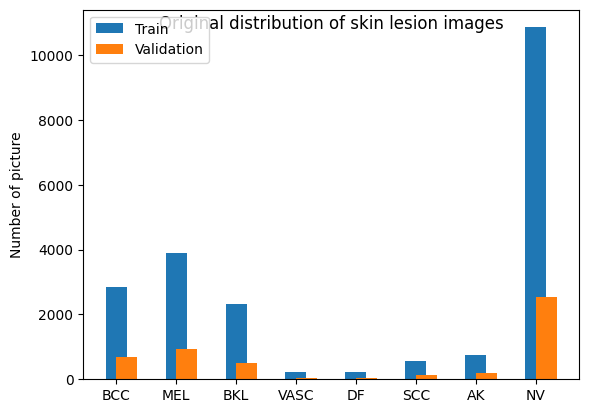

In [50]:
import matplotlib.pyplot as plt

# Plotting the grouped bar chart
fig, ax = plt.subplots()
width = 0.35  # Width of the bars

train_bars = ax.bar(
    total_files_train_df.columns.to_list(),
    total_files_train_df.iloc[0,:].to_list(),
    width, label='Train')

validation_bars = ax.bar(
    total_files_val_df.columns.to_list(),
    total_files_val_df.iloc[0,:].to_list(),
    width, label='Validation', align='edge')

# Adding labels, title, and legend
ax.set_ylabel('Number of picture')
ax.set_title('Original distribution of skin lesion images')
ax.legend()

# Show the plot
plt.show()

## 3.3 Data Wrangling

Due to the large imbalance we have in some of the classes, we apply a random trimming in them to make each class as equal as possible.

In [71]:
def copy_pictures(source_path, destination_path, max_files, shufle=False):

    n = 0

    print('Copying files')
    print(f'From: {source_path}')
    print(f'To: {destination_path}')
    print(f'Pictures Number to copy: {max_files}')
    print('Moving files into the folder structure')
    print('--------------------------------------')
    for root, dirs, files in os.walk(source_path):
        print(root, dirs, files)
        if n!=0:
            print(root)

            if len(files)>= max_files:
                max = max_files
            else:
                max = len(files)

            if shufle:
                files = random.sample(files, len(files))

            for i in range(max):
                #print(files[i]) #Verbose mode
                label = root.split('/')[-1]
                shutil.copy2(
                    os.path.join(root,files[i]),
                    os.path.join(destination_path, label, files[i])
                )
        else:
            # Review if the folder structure exist
            labels = dirs
            print(labels)
            for f in labels:
                try:
                    os.mkdir(os.path.join(destination_path, f))
                except:
                    print(f'Folder {f} exist. Deleting it')
        n += 1
    print('Process finished')

In [21]:
# Constant. It is used to define the maximum number of picture by class.
NUM_FILES_TRAIN = 300

In [72]:
# Train dataset

source_path = '/content/drive/MyDrive/Colab Notebooks/Master UOC/TFM/Dermatological lesion classification/Data/Train2'
train_path = '/content/drive/MyDrive/Colab Notebooks/Master UOC/TFM/Dermatological lesion classification/Data/Train3'

labels = ['BCC', 'MEL', 'BKL', 'VASC', 'DF', 'SCC', 'AK', 'NV']
n = 0
if 1==0: # We recreate the reduced train directory.
    for f in labels:
        try:
            os.mkdir(os.path.join(train_path, f))
        except:
            print(f'Folder {f} exist. Deleting it')
            shutil.rmtree(os.path.join(train_path, f))


    copy_pictures(source_path=source_path,
                  destination_path=train_path,
                  max_files=NUM_FILES_TRAIN)

Folder BCC exist. Deleting it
Folder MEL exist. Deleting it
Folder BKL exist. Deleting it
Folder VASC exist. Deleting it
Folder DF exist. Deleting it
Folder SCC exist. Deleting it
Folder AK exist. Deleting it
Folder NV exist. Deleting it
Copying files
From: /content/drive/MyDrive/Colab Notebooks/Master UOC/TFM/Dermatological lesion classification/Data/Train2
To: /content/drive/MyDrive/Colab Notebooks/Master UOC/TFM/Dermatological lesion classification/Data/Train3
Pictures Number to copy: 300
Moving files into the folder structure
--------------------------------------
/content/drive/MyDrive/Colab Notebooks/Master UOC/TFM/Dermatological lesion classification/Data/Train2 ['BCC', 'MEL', 'BKL', 'VASC', 'DF', 'SCC', 'AK', 'NV'] []
['BCC', 'MEL', 'BKL', 'VASC', 'DF', 'SCC', 'AK', 'NV']
/content/drive/MyDrive/Colab Notebooks/Master UOC/TFM/Dermatological lesion classification/Data/Train2/BCC [] ['ISIC_0070309.jpg', 'ISIC_0029539.jpg', 'ISIC_0070233.jpg', 'ISIC_0057355.jpg', 'ISIC_0057941.jpg'

In [60]:
# Validation dataset

num_files_valid = int(NUM_FILES_TRAIN * 0.2)
source_path = '/content/drive/MyDrive/Colab Notebooks/Master UOC/TFM/Dermatological lesion classification/Data/Valid'
valid_path = '/content/drive/MyDrive/Colab Notebooks/Master UOC/TFM/Dermatological lesion classification/Data/Valid3'
n = 0
if 1 == 0: # We recreate the reduced validation directory
    copy_pictures(source_path=source_path,
                  destination_path=valid_path,
                  max_files=num_files_valid)

Since the original dataset **lacks the test labels**, we will generate a dataset from random train images.

In [61]:
# test dataset

num_files_test = int(NUM_FILES_TRAIN * 0.2)
main_path = '/content/drive/MyDrive/Colab Notebooks/Master UOC/TFM/Dermatological lesion classification/Data/'
source_path = '/content/drive/MyDrive/Colab Notebooks/Master UOC/TFM/Dermatological lesion classification/Data/Train2'
test_path = '/content/drive/MyDrive/Colab Notebooks/Master UOC/TFM/Dermatological lesion classification/Data/Test3'
n = 0
y_test = list()

if 1 == 0: # We recreate the reduced test directory
    copy_pictures(source_path=source_path,
                  destination_path=test_path,
                  max_files=num_files_test)


We calculate and drawing the result of the data set after applying the random trim to the majority classes.

In [106]:
def total_pictures_dir(folder):
    df = pd.DataFrame()
    n = 0
    for root, dirs, files in os.walk(folder):
        if n!=0:
            #print(root.split('/')[-1], dirs, len(files)) #Turn it on for Verbose mode
            df[root.split('/')[-1]] = [len(files)]
        n += 1
    return(df)

total_files_train_df = total_pictures_dir(images_train_path)
total_files_val_df = total_pictures_dir(images_valid_path)
total_files_test_df = total_pictures_dir(images_path_test2)

print(f'# Train: ')
print(total_files_train_df)
print()
print(f'# Validation: ')
print(total_files_val_df)
print()
print(f'Test: {total_files_test_df}')

# Train: 
   BCC  MEL  BKL  VASC   DF  SCC   AK   NV
0  300  300  300   300  300  300  300  300

# Validation: 
   BCC  MEL  BKL  VASC  DF  SCC  AK  NV
0   50   50   50    46  45   50  50  50

Test:    Test
0  8238


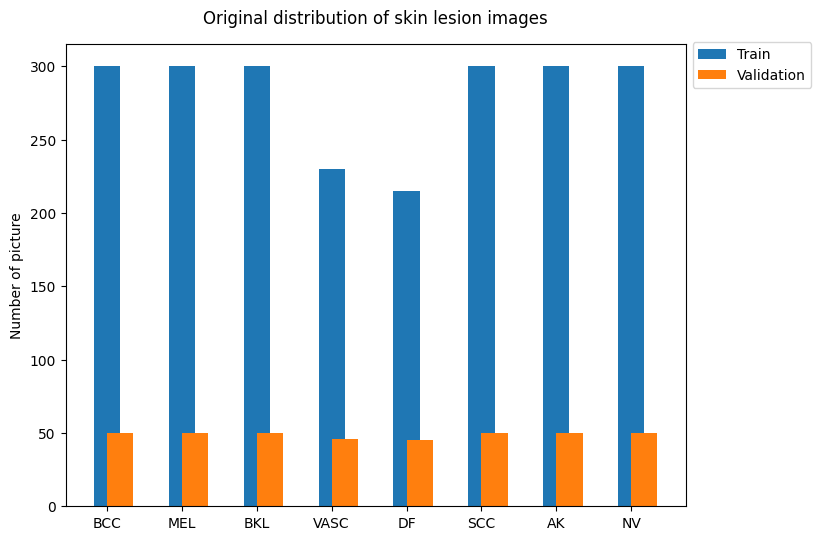

In [87]:
# Plotting the grouped bar chart
fig, ax = plt.subplots(figsize=(8,6))
width = 0.35  # Width of the bars

train_bars = ax.bar(
    total_files_train_df.columns.to_list(),
    total_files_train_df.iloc[0,:].to_list(),
    width, label='Train')

validation_bars = ax.bar(
    total_files_val_df.columns.to_list(),
    total_files_val_df.iloc[0,:].to_list(),
    width, label='Validation', align='edge')

# Adding labels, title, and legend
ax.set_ylabel('Number of picture')
ax.set_title('Original distribution of skin lesion images')

ax.legend(bbox_to_anchor=(1.0, 1.02))
plt.rcParams['axes.titlepad'] = 15.0

# Show the plot
plt.show()

## 3.4 Artificial image generation through the SMOTE process.

### 3.4.1 SMOTE example

In [9]:
target_size = (224, 224)
n_channels = 3
batch_size = 32
seed = 1234

imagegen = ImageDataGenerator()

# load train data from drive
my_folder = '/content/drive/MyDrive/Colab Notebooks/Master UOC/TFM/Dermatological lesion classification/Data/Sintetic_generation/'

train_generator=imagegen.flow_from_directory(
    my_folder,
    class_mode="categorical",
    shuffle=False,
    batch_size=batch_size,
    target_size=target_size,
    seed=seed)

x = np.concatenate([train_generator.next()[0] for i in range(train_generator.__len__())])
y = np.concatenate([train_generator.next()[1] for i in range(train_generator.__len__())])

print(x.shape)
print(y.shape)
print(train_generator.class_indices)
n_images = x.shape[0]

#Converting our color images to a vector
X_train=x.reshape(n_images,224*224*3)

# Apply SMOTE method
# https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html

# Dictionary with the desired sizing
sample_dict = {0:6, 1:6}


sm = SMOTE(sampling_strategy=sample_dict, k_neighbors=3, random_state=seed)
X_smote, y_smote = sm.fit_resample(X_train, y)

#Retrieve the image and save it to drive. Here's an example for a single image
n_images_generated = len(X_smote)
print(n_images_generated)

Xsmote_img=X_smote.reshape(n_images_generated,target_size[0], target_size[0],n_channels)

Found 10 images belonging to 2 classes.
(10, 224, 224, 3)
(10, 2)
{'DF': 0, 'VASC': 1}
12


Text(0.5, 0.98, 'Artificial new images generated by Smote method')

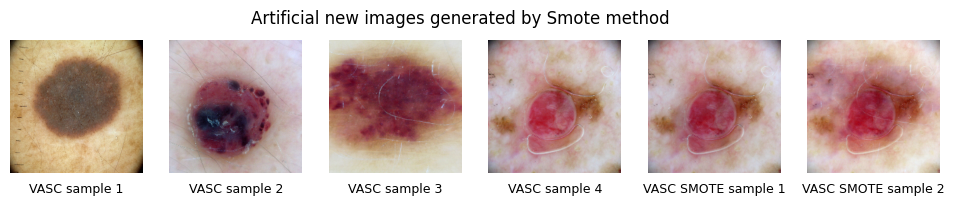

In [10]:
# Drawing the image selected

target_size = (224, 224)
n_channels = 3
pointer = 4
X_smote_img = X_smote.reshape(n_images_generated,target_size[0], target_size[0],n_channels)

# Drawing the image selected
c = 6 # columns

fig, ax = plt.subplots(nrows=1, ncols=c, figsize=(12,2))
vasc_label = ['VASC sample 1', 'VASC sample 2', 'VASC sample 3', 'VASC sample 4', 'VASC SMOTE sample 1', 'VASC SMOTE sample 2']
for i in range(n_images_generated):
    # The Minority class will be drawn only.
    if i > (n_images_generated /2 - 1):
        pil_img = array_to_img(Xsmote_img[i]* 255)
        ax[i - c].imshow(pil_img)
        ax[i - c].axis('off')

        label = vasc_label[i - c]
        ax[i - c].set_title(label, y=1.0, pad=-110, fontsize = 9)
        # ax[r + 1, i - c].set_title(label, y=1.0, pad=10)

plt.suptitle('Artificial new images generated by Smote method')

### 3.4.2 Up-samling minority class with SMOTE

In [22]:
from imblearn.over_sampling import SMOTE

target_size = (224, 224)
picture_dimensions = (224*224*3)
n_channels = 3
batch_size = 32
seed = 1234

# load train data from drive
my_folder = images_train_path
imagegen = ImageDataGenerator()

train_generator = imagegen.flow_from_directory(
    directory=my_folder,
    class_mode="categorical",
    shuffle=False,
    batch_size=batch_size,
    target_size=target_size,
    seed=seed)

# Serializing the pictures and labels
x = np.concatenate([train_generator.next()[0] for i in range(train_generator.__len__())])
y = np.concatenate([train_generator.next()[1] for i in range(train_generator.__len__())])

#print(x.shape)
#print(y.shape)
n_images = x.shape[0]

#Converting our color images to a vector
X_train=x.reshape(n_images, picture_dimensions)

# Identify the classes
class_dict = {v: k for k, v in train_generator.class_indices.items()}
class_dict

Found 2400 images belonging to 8 classes.


{0: 'AK', 1: 'BCC', 2: 'BKL', 3: 'DF', 4: 'MEL', 5: 'NV', 6: 'SCC', 7: 'VASC'}

In [30]:
# Apply SMOTE method
# https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html

# Dictionary with the desired sizing
sample_dict = {0:NUM_FILES_TRAIN,
               1:NUM_FILES_TRAIN,
               2:NUM_FILES_TRAIN,
               3:NUM_FILES_TRAIN,
               4:NUM_FILES_TRAIN,
               5:NUM_FILES_TRAIN,
               6:NUM_FILES_TRAIN,
               7:NUM_FILES_TRAIN}


sm = SMOTE(sampling_strategy=sample_dict, random_state=2)
X_smote, y_smote = sm.fit_resample(X_train, y)

print(f'Images number artificially generated: {len(y_smote) - len(train_generator.classes)}')

# Identify the classes generated by smote
new_images = list()
new_images = y_smote[len(train_generator.classes):]
new_images = [np.argmax(i) for i in new_images]
idx = np.unique(new_images)
print(f'New pictures are of the classes: {class_dict[idx[0]]} y  {class_dict[idx[1]]')

Images number artificially generated: 155


Text(0.5, 0.98, 'Artificial new images generated by Smote method')

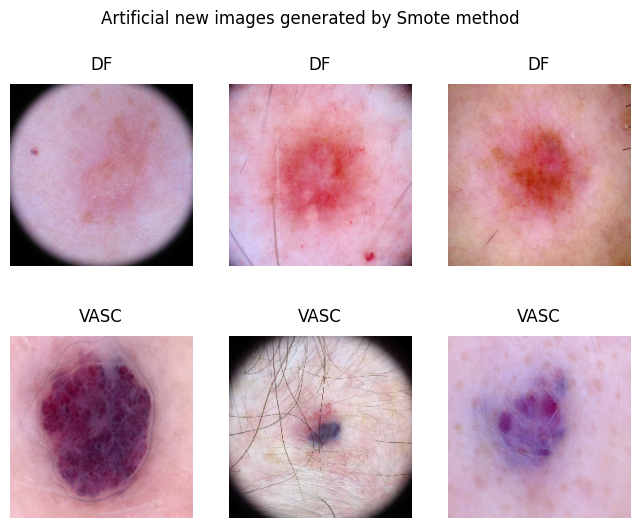

In [93]:
from keras.preprocessing.image import array_to_img, img_to_array

target_size = (224, 224)
n_channels = 3
pointer = 85
n_images_generated = len(X_smote)

X_smote_img = X_smote.reshape(n_images_generated,target_size[0], target_size[0],n_channels)

# Drawing the image selected
c = 3 # columns
r = 0 # rows
n_pictures = 6

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(8,6))

for i in range(n_pictures):
    if i < n_pictures /2:
        p = len(train_generator.classes) + i
        pil_img = array_to_img(Xsmote_img[p]* 255)
        ax[r, i].imshow(pil_img)
        ax[r, i].axis('off')

        label = class_dict[np.argmax(y_smote[p])]
        ax[r, i].set_title(label, y=1.0, pad=10)
    else:
        p = len(train_generator.classes) + pointer + i
        pil_img = array_to_img(Xsmote_img[p]* 255)
        ax[r + 1, i - c].imshow(pil_img)
        ax[r + 1, i - c].axis('off')

        label = class_dict[np.argmax(y_smote[p])]
        ax[r + 1, i - c].set_title(label, y=1.0, pad=10)

plt.suptitle('Artificial new images generated by Smote method')

In [103]:
# Saving new images into disc
p_initial = len(train_generator.classes)
n_new_images = len(y_smote) - len(train_generator.classes)

for 1 == 0: #Avoit saving by error
    for i in range(n_new_images):
        p = p_initial + i
        class_folder = class_dict[np.argmax(y_smote[p])]
        #print('Picture: ', i, ' - ', class_folder)

        pil_img = array_to_img(Xsmote_img[p]* 255)
        pil_img.save(os.path.join(my_folder, class_folder, 'smote_img_' + str(i) + '.jpg'))

Picture:  0  -  DF
Picture:  1  -  DF
Picture:  2  -  DF
Picture:  3  -  DF
Picture:  4  -  DF
Picture:  5  -  DF
Picture:  6  -  DF
Picture:  7  -  DF
Picture:  8  -  DF
Picture:  9  -  DF
Picture:  10  -  DF
Picture:  11  -  DF
Picture:  12  -  DF
Picture:  13  -  DF
Picture:  14  -  DF
Picture:  15  -  DF
Picture:  16  -  DF
Picture:  17  -  DF
Picture:  18  -  DF
Picture:  19  -  DF
Picture:  20  -  DF
Picture:  21  -  DF
Picture:  22  -  DF
Picture:  23  -  DF
Picture:  24  -  DF
Picture:  25  -  DF
Picture:  26  -  DF
Picture:  27  -  DF
Picture:  28  -  DF
Picture:  29  -  DF
Picture:  30  -  DF
Picture:  31  -  DF
Picture:  32  -  DF
Picture:  33  -  DF
Picture:  34  -  DF
Picture:  35  -  DF
Picture:  36  -  DF
Picture:  37  -  DF
Picture:  38  -  DF
Picture:  39  -  DF
Picture:  40  -  DF
Picture:  41  -  DF
Picture:  42  -  DF
Picture:  43  -  DF
Picture:  44  -  DF
Picture:  45  -  DF
Picture:  46  -  DF
Picture:  47  -  DF
Picture:  48  -  DF
Picture:  49  -  DF
Picture:  

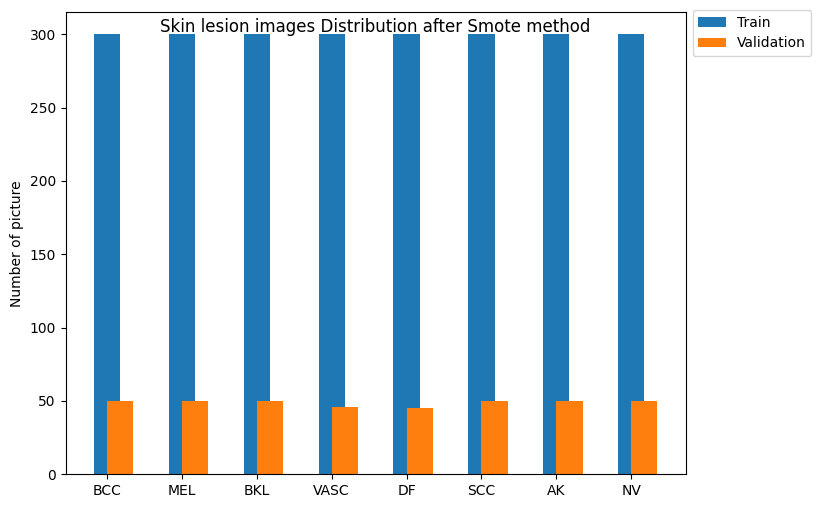

In [107]:
# New training Calculation
total_files_train_df_2 = total_pictures_dir(images_train_path)

# Plotting the grouped bar chart
fig, ax = plt.subplots(figsize=(8,6))
width = 0.35  # Width of the bars

train_bars = ax.bar(
    total_files_train_df_2.columns.to_list(),
    total_files_train_df_2.iloc[0,:].to_list(),
    width, label='Train')

validation_bars = ax.bar(
    total_files_val_df.columns.to_list(),
    total_files_val_df.iloc[0,:].to_list(),
    width, label='Validation', align='edge')

# Adding labels, title, and legend
ax.set_ylabel('Number of picture')
ax.set_title('Skin lesion images Distribution after Smote method')

ax.legend(bbox_to_anchor=(1.0, 1.02))
plt.rcParams['axes.titlepad'] = 15.0

# Show the plot
plt.show()

# 4 - Transfer Learning with Efficient B0

Our first 3 models will use EfficientNet as a feature extractor.

For the case of the base model EfficientNet version B0, it is designed to take input images with a shape (224, 224, 3) and whose input values are between [0 and 255], since the model includes a normalization stage as part of the model.

https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/

## 4.1 Hyperparameters Search

The first step is to find the best combination of hyperparameters. For this purpose, with a small number of epochs and a fixed batch size, the best combination of **learning rate** is searched according to two optimizers: **Adam** and **SGD**. As a model, we start from the base model, freezing all the layers of the extractor and training only the classifier.


In [ ]:
# Base model modification

# Model Parameters
seed = 1234
model_name = "model1_1"
n_classes = 8
shape = (224, 224, 3)


# Base model definition
# https://keras.io/api/applications/efficientnet/#efficientnetb1-function

base_model = EfficientNetB0(include_top=False,
                            input_shape=shape,
                            weights="imagenet")
base_model.trainable = False

model1 = build_model(base_model, n_classes, shape, model_name, seed)
model1.summary(show_trainable=True)

16705208/16705208 [==============================] - 2s 0us/step
Model: "model1_1"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         Y          
                                                                            
 efficientnetb0 (Functional  (None, 7, 7, 1280)        4049571   N          
 )                                                                          
                                                                            
 avg_pool (GlobalAveragePoo  (None, 1280)              0         Y          
 ling2D)                                                                    
                                                                            
 batch_normalization (Batch  (None, 1280)              5120      Y          
 Normalization)                                                       

In the configuration of our base model, we have eliminated the upper layers that are responsible for performing the prediction.

The feature extractor is set to not trainable.

In [ ]:
############################################
# Model 1 Searching hyperparameters Step
############################################

# Fix Training Parameters
batch_size = 32
epochs = 20
momentum = 0.9
augmentation = False
seed = 1234
target_size = (224, 224)
color_mode = 'rgb'

# Variables Training Parameters
learning_rate = [1e-4, 5e-4, 1e-3, 5e-3, 1e-2]
optimizer = ['SGD', 'RMSprop', 'Adam']
# learning_rate = [1e-3, 1e-2]
# optimizer = ['Adam']

optimizer_dict = dict()
valid_loss_dict = dict()
valid_acc_dict = dict()
time_dict = dict()

# Path images
train_path = images_train_path
val_path = images_valid_path
test_path = images_test_path

# Data augmentation config
train_generator, valid_generator, test_generator = image_generator(
    train_path=train_path,
    val_path=val_path,
    test_path=test_path,
    target_size=target_size,
    batch_size=batch_size,
    color_mode=color_mode,
    augmentation = augmentation)

STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n // valid_generator.batch_size
STEP_SIZE_TEST = test_generator.n // test_generator.batch_size

print(f'Train Step size: {STEP_SIZE_TRAIN}')
print(f'Validation Step size: {STEP_SIZE_VALID}')
print(f'Test Step size: {STEP_SIZE_TEST}')

# Callback definition:
es = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 10)

n = 0

print('The search for hyperparameters has begun')
print('=========================================')
for opt in optimizer:
    print(f'Optimizer: {opt}')
    print('----------')
    for lr in learning_rate:
        model1 = build_model(base_model, n_classes, shape, model_name, seed)
        df = pd.DataFrame(columns = ['epoch', 'loss', 'acc'])
        print(f'Learning Rate {lr}')

        if opt == 'Adam':
            optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
        elif opt == 'SGD':
            optimizer = tf.keras.optimizers.SGD(learning_rate=lr,
                                                momentum = momentum
                                                )
        elif opt == 'RMSprop':
            optimizer = tf.keras.optimizers.RMSprop(learning_rate=lr,
                                                    momentum = momentum
                                                    )

        # Model compilation
        model1.compile(
            optimizer=optimizer,
            loss="categorical_crossentropy",
            metrics=['accuracy']
        )

        # Training the model
        print('>> Training process Start')

        # Time started
        start_time = time.time()

        model1_history = model1.fit(
            train_generator,
            steps_per_epoch=STEP_SIZE_TRAIN,
            validation_data=valid_generator,
            validation_steps=STEP_SIZE_VALID,
            epochs=epochs,
            callbacks=[es, TqdmCallback(verbose=1)]
            )

        end_time = time.time() - start_time

        # Storage the accuracy score and loss for each learning rate value
        valid_loss_dict[lr] = model1_history.history['val_loss']
        valid_acc_dict[lr] = model1_history.history['val_accuracy']
        time_dict[lr] = end_time

        # Calculating the main indicators
        print('>> The Training has finished')
        print(f'Time execution: {end_time}')
        print('--------------')
        del model1 # Used for ensure the garbage out
        del model1_history
        n += 1
    optimizer_dict[opt] = {'valid_loss_dict': valid_loss_dict,
                           'valid_acc_dict': valid_acc_dict,
                           'lr': learning_rate,
                           'time': time_dict
                           }

    valid_loss_dict = dict()
    valid_acc_dict = dict()
    time_dict = dict()
    n = 0
print('>> Hyperparameters search completed')


Generating pictures
Found 1945 images belonging to 8 classes.
Found 391 images belonging to 8 classes.
Found 400 images belonging to 8 classes.
Train Step size: 60
Validation Step size: 12
Test Step size: 400
The search for hyperparameters has begun
Optimizer: SGD
----------
Learning Rate 0.0001
>> Training process Start


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/20
60/60 [==============================] - 1725s 29s/step - loss: 2.8942 - accuracy: 0.1312 - val_loss: 2.0987 - val_accuracy: 0.1667
Epoch 2/20
60/60 [==============================] - 24s 402ms/step - loss: 2.5577 - accuracy: 0.1615 - val_loss: 2.0489 - val_accuracy: 0.1953
Epoch 3/20
60/60 [==============================] - 24s 408ms/step - loss: 2.3799 - accuracy: 0.2101 - val_loss: 2.0133 - val_accuracy: 0.2214
Epoch 4/20
60/60 [==============================] - 24s 401ms/step - loss: 2.2799 - accuracy: 0.2180 - val_loss: 1.9855 - val_accuracy: 0.2474
Epoch 5/20
60/60 [==============================] - 24s 405ms/step - loss: 2.1815 - accuracy: 0.2530 - val_loss: 1.9617 - val_accuracy: 0.2500
Epoch 6/20
60/60 [==============================] - 25s 410ms/step - loss: 2.1212 - accuracy: 0.2703 - val_loss: 1.9448 - val_accuracy: 0.2578
Epoch 7/20
60/60 [==============================] - 24s 406ms/step - loss: 2.0310 - accuracy: 0.2980 - val_loss: 1.9321 - val_accuracy: 0.2656

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/20
60/60 [==============================] - 32s 434ms/step - loss: 2.5783 - accuracy: 0.1741 - val_loss: 1.9734 - val_accuracy: 0.2240
Epoch 2/20
60/60 [==============================] - 24s 403ms/step - loss: 2.0735 - accuracy: 0.2781 - val_loss: 1.8356 - val_accuracy: 0.2995
Epoch 3/20
60/60 [==============================] - 24s 399ms/step - loss: 1.8896 - accuracy: 0.3377 - val_loss: 1.7441 - val_accuracy: 0.3490
Epoch 4/20
60/60 [==============================] - 24s 403ms/step - loss: 1.7235 - accuracy: 0.3842 - val_loss: 1.6931 - val_accuracy: 0.3542
Epoch 5/20
60/60 [==============================] - 24s 396ms/step - loss: 1.6374 - accuracy: 0.4156 - val_loss: 1.6488 - val_accuracy: 0.3802
Epoch 6/20
60/60 [==============================] - 24s 400ms/step - loss: 1.5695 - accuracy: 0.4616 - val_loss: 1.6269 - val_accuracy: 0.4036
Epoch 7/20
60/60 [==============================] - 24s 401ms/step - loss: 1.5171 - accuracy: 0.4590 - val_loss: 1.6092 - val_accuracy: 0.4089

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/20
60/60 [==============================] - 32s 428ms/step - loss: 2.4152 - accuracy: 0.2143 - val_loss: 1.8685 - val_accuracy: 0.3047
Epoch 2/20
60/60 [==============================] - 24s 401ms/step - loss: 1.8996 - accuracy: 0.3555 - val_loss: 1.7542 - val_accuracy: 0.3333
Epoch 3/20
60/60 [==============================] - 24s 400ms/step - loss: 1.6902 - accuracy: 0.4030 - val_loss: 1.6896 - val_accuracy: 0.3594
Epoch 4/20
60/60 [==============================] - 24s 398ms/step - loss: 1.5472 - accuracy: 0.4574 - val_loss: 1.6318 - val_accuracy: 0.3724
Epoch 5/20
60/60 [==============================] - 24s 403ms/step - loss: 1.4320 - accuracy: 0.4956 - val_loss: 1.5953 - val_accuracy: 0.3958
Epoch 6/20
60/60 [==============================] - 24s 400ms/step - loss: 1.3869 - accuracy: 0.5212 - val_loss: 1.5793 - val_accuracy: 0.3880
Epoch 7/20
60/60 [==============================] - 24s 404ms/step - loss: 1.2931 - accuracy: 0.5389 - val_loss: 1.5887 - val_accuracy: 0.4036

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/20
60/60 [==============================] - 32s 433ms/step - loss: 2.2152 - accuracy: 0.2927 - val_loss: 1.7133 - val_accuracy: 0.3464
Epoch 2/20
60/60 [==============================] - 24s 406ms/step - loss: 1.5689 - accuracy: 0.4673 - val_loss: 1.6991 - val_accuracy: 0.3828
Epoch 3/20
60/60 [==============================] - 24s 408ms/step - loss: 1.3587 - accuracy: 0.5217 - val_loss: 1.6413 - val_accuracy: 0.3906
Epoch 4/20
60/60 [==============================] - 25s 411ms/step - loss: 1.2315 - accuracy: 0.5682 - val_loss: 1.6070 - val_accuracy: 0.4115
Epoch 5/20
60/60 [==============================] - 24s 407ms/step - loss: 1.1429 - accuracy: 0.5985 - val_loss: 1.6536 - val_accuracy: 0.4115
Epoch 6/20
60/60 [==============================] - 24s 400ms/step - loss: 1.0493 - accuracy: 0.6268 - val_loss: 1.6968 - val_accuracy: 0.4271
Epoch 7/20
60/60 [==============================] - 25s 408ms/step - loss: 1.0143 - accuracy: 0.6367 - val_loss: 1.7066 - val_accuracy: 0.4297

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/20
60/60 [==============================] - 32s 440ms/step - loss: 2.3357 - accuracy: 0.3298 - val_loss: 1.7798 - val_accuracy: 0.3021
Epoch 2/20
60/60 [==============================] - 24s 402ms/step - loss: 1.7432 - accuracy: 0.4773 - val_loss: 1.7694 - val_accuracy: 0.3359
Epoch 3/20
60/60 [==============================] - 24s 398ms/step - loss: 1.5292 - accuracy: 0.5353 - val_loss: 1.7800 - val_accuracy: 0.3906
Epoch 4/20
60/60 [==============================] - 24s 402ms/step - loss: 1.3326 - accuracy: 0.5787 - val_loss: 1.8447 - val_accuracy: 0.3828
Epoch 5/20
60/60 [==============================] - 24s 404ms/step - loss: 1.2803 - accuracy: 0.5902 - val_loss: 1.9027 - val_accuracy: 0.4062
Epoch 6/20
60/60 [==============================] - 24s 399ms/step - loss: 1.2849 - accuracy: 0.5964 - val_loss: 2.0889 - val_accuracy: 0.4010
Epoch 7/20
60/60 [==============================] - 24s 398ms/step - loss: 1.2093 - accuracy: 0.6289 - val_loss: 2.1375 - val_accuracy: 0.3958

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/20
60/60 [==============================] - 32s 434ms/step - loss: 2.3784 - accuracy: 0.2321 - val_loss: 1.8443 - val_accuracy: 0.2812
Epoch 2/20
60/60 [==============================] - 24s 401ms/step - loss: 1.7758 - accuracy: 0.3832 - val_loss: 1.7220 - val_accuracy: 0.3385
Epoch 3/20
60/60 [==============================] - 24s 395ms/step - loss: 1.5708 - accuracy: 0.4532 - val_loss: 1.6591 - val_accuracy: 0.3333
Epoch 4/20
60/60 [==============================] - 24s 400ms/step - loss: 1.4370 - accuracy: 0.4961 - val_loss: 1.6021 - val_accuracy: 0.3932
Epoch 5/20
60/60 [==============================] - 24s 394ms/step - loss: 1.3010 - accuracy: 0.5395 - val_loss: 1.5929 - val_accuracy: 0.3724
Epoch 6/20
60/60 [==============================] - 24s 396ms/step - loss: 1.2216 - accuracy: 0.5719 - val_loss: 1.5644 - val_accuracy: 0.4219
Epoch 7/20
60/60 [==============================] - 24s 402ms/step - loss: 1.1492 - accuracy: 0.5933 - val_loss: 1.5698 - val_accuracy: 0.4323

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/20
60/60 [==============================] - 31s 427ms/step - loss: 2.3184 - accuracy: 0.3298 - val_loss: 1.7320 - val_accuracy: 0.3594
Epoch 2/20
60/60 [==============================] - 24s 400ms/step - loss: 1.5839 - accuracy: 0.4797 - val_loss: 1.6852 - val_accuracy: 0.3385
Epoch 3/20
60/60 [==============================] - 24s 400ms/step - loss: 1.4638 - accuracy: 0.5196 - val_loss: 1.7036 - val_accuracy: 0.4062
Epoch 4/20
60/60 [==============================] - 24s 399ms/step - loss: 1.2574 - accuracy: 0.5797 - val_loss: 1.6733 - val_accuracy: 0.4271
Epoch 5/20
60/60 [==============================] - 24s 398ms/step - loss: 1.1766 - accuracy: 0.6085 - val_loss: 1.8145 - val_accuracy: 0.3932
Epoch 6/20
60/60 [==============================] - 24s 393ms/step - loss: 1.1778 - accuracy: 0.6043 - val_loss: 1.9147 - val_accuracy: 0.4245
Epoch 7/20
60/60 [==============================] - 24s 400ms/step - loss: 1.1503 - accuracy: 0.6200 - val_loss: 1.9868 - val_accuracy: 0.4089

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/20
60/60 [==============================] - 32s 421ms/step - loss: 2.8830 - accuracy: 0.3136 - val_loss: 2.1714 - val_accuracy: 0.2656
Epoch 2/20
60/60 [==============================] - 24s 396ms/step - loss: 2.1106 - accuracy: 0.4658 - val_loss: 1.8991 - val_accuracy: 0.3490
Epoch 3/20
60/60 [==============================] - 24s 395ms/step - loss: 1.8170 - accuracy: 0.5081 - val_loss: 2.0937 - val_accuracy: 0.3516
Epoch 4/20
60/60 [==============================] - 24s 406ms/step - loss: 1.7939 - accuracy: 0.5416 - val_loss: 2.0704 - val_accuracy: 0.3698
Epoch 5/20
60/60 [==============================] - 24s 402ms/step - loss: 1.5242 - accuracy: 0.6048 - val_loss: 2.1032 - val_accuracy: 0.4141
Epoch 6/20
60/60 [==============================] - 24s 401ms/step - loss: 1.6349 - accuracy: 0.5808 - val_loss: 2.2186 - val_accuracy: 0.4479
Epoch 7/20
60/60 [==============================] - 24s 394ms/step - loss: 1.5771 - accuracy: 0.5813 - val_loss: 2.5572 - val_accuracy: 0.4349

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/20
60/60 [==============================] - 31s 428ms/step - loss: 9.0328 - accuracy: 0.2974 - val_loss: 5.7414 - val_accuracy: 0.2318
Epoch 2/20
60/60 [==============================] - 24s 402ms/step - loss: 5.6387 - accuracy: 0.4088 - val_loss: 3.0134 - val_accuracy: 0.3542
Epoch 3/20
60/60 [==============================] - 25s 408ms/step - loss: 4.9859 - accuracy: 0.4161 - val_loss: 4.6152 - val_accuracy: 0.2161
Epoch 4/20
60/60 [==============================] - 24s 397ms/step - loss: 4.8181 - accuracy: 0.4156 - val_loss: 4.7728 - val_accuracy: 0.3021
Epoch 5/20
60/60 [==============================] - 24s 398ms/step - loss: 4.1593 - accuracy: 0.4171 - val_loss: 3.3759 - val_accuracy: 0.3411
Epoch 6/20
60/60 [==============================] - 24s 405ms/step - loss: 3.9126 - accuracy: 0.4511 - val_loss: 5.2480 - val_accuracy: 0.3073
Epoch 7/20
60/60 [==============================] - 24s 400ms/step - loss: 4.2771 - accuracy: 0.4328 - val_loss: 4.5881 - val_accuracy: 0.3307

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/20
60/60 [==============================] - 31s 426ms/step - loss: 18.8138 - accuracy: 0.2854 - val_loss: 15.3885 - val_accuracy: 0.2240
Epoch 2/20
60/60 [==============================] - 24s 407ms/step - loss: 13.8546 - accuracy: 0.3649 - val_loss: 10.2007 - val_accuracy: 0.2214
Epoch 3/20
60/60 [==============================] - 24s 401ms/step - loss: 14.4670 - accuracy: 0.3523 - val_loss: 10.3735 - val_accuracy: 0.2917
Epoch 4/20
60/60 [==============================] - 24s 400ms/step - loss: 14.2021 - accuracy: 0.3727 - val_loss: 11.7464 - val_accuracy: 0.2839
Epoch 5/20
60/60 [==============================] - 24s 400ms/step - loss: 14.7487 - accuracy: 0.3696 - val_loss: 8.8401 - val_accuracy: 0.3594
Epoch 6/20
60/60 [==============================] - 24s 399ms/step - loss: 13.3382 - accuracy: 0.3816 - val_loss: 12.5905 - val_accuracy: 0.3255
Epoch 7/20
60/60 [==============================] - 25s 415ms/step - loss: 13.1591 - accuracy: 0.3999 - val_loss: 15.7503 - val_acc

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/20
60/60 [==============================] - 32s 417ms/step - loss: 2.6343 - accuracy: 0.1537 - val_loss: 2.0714 - val_accuracy: 0.1901
Epoch 2/20
60/60 [==============================] - 24s 405ms/step - loss: 2.4459 - accuracy: 0.2002 - val_loss: 1.9996 - val_accuracy: 0.2188
Epoch 3/20
60/60 [==============================] - 24s 396ms/step - loss: 2.2712 - accuracy: 0.2154 - val_loss: 1.9415 - val_accuracy: 0.2656
Epoch 4/20
60/60 [==============================] - 24s 402ms/step - loss: 2.1450 - accuracy: 0.2676 - val_loss: 1.9009 - val_accuracy: 0.2786
Epoch 5/20
60/60 [==============================] - 24s 409ms/step - loss: 2.0194 - accuracy: 0.2943 - val_loss: 1.8682 - val_accuracy: 0.3229
Epoch 6/20
60/60 [==============================] - 24s 398ms/step - loss: 2.0010 - accuracy: 0.3058 - val_loss: 1.8436 - val_accuracy: 0.3203
Epoch 7/20
60/60 [==============================] - 24s 406ms/step - loss: 1.9053 - accuracy: 0.3231 - val_loss: 1.8255 - val_accuracy: 0.3281

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/20
60/60 [==============================] - 32s 427ms/step - loss: 2.3756 - accuracy: 0.2138 - val_loss: 1.9317 - val_accuracy: 0.2448
Epoch 2/20
60/60 [==============================] - 24s 400ms/step - loss: 1.9186 - accuracy: 0.3236 - val_loss: 1.8164 - val_accuracy: 0.2943
Epoch 3/20
60/60 [==============================] - 24s 402ms/step - loss: 1.7224 - accuracy: 0.3889 - val_loss: 1.7400 - val_accuracy: 0.3385
Epoch 4/20
60/60 [==============================] - 24s 400ms/step - loss: 1.5759 - accuracy: 0.4245 - val_loss: 1.6815 - val_accuracy: 0.3568
Epoch 5/20
60/60 [==============================] - 24s 401ms/step - loss: 1.4987 - accuracy: 0.4626 - val_loss: 1.6379 - val_accuracy: 0.3776
Epoch 6/20
60/60 [==============================] - 24s 394ms/step - loss: 1.3965 - accuracy: 0.5044 - val_loss: 1.6179 - val_accuracy: 0.3958
Epoch 7/20
60/60 [==============================] - 24s 399ms/step - loss: 1.3308 - accuracy: 0.5238 - val_loss: 1.6124 - val_accuracy: 0.3958

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/20
60/60 [==============================] - 32s 434ms/step - loss: 2.2548 - accuracy: 0.2535 - val_loss: 1.8023 - val_accuracy: 0.3177
Epoch 2/20
60/60 [==============================] - 24s 404ms/step - loss: 1.7194 - accuracy: 0.4166 - val_loss: 1.7107 - val_accuracy: 0.3594
Epoch 3/20
60/60 [==============================] - 25s 411ms/step - loss: 1.4981 - accuracy: 0.4710 - val_loss: 1.6406 - val_accuracy: 0.3750
Epoch 4/20
60/60 [==============================] - 24s 404ms/step - loss: 1.3923 - accuracy: 0.5097 - val_loss: 1.5911 - val_accuracy: 0.4062
Epoch 5/20
60/60 [==============================] - 24s 404ms/step - loss: 1.2878 - accuracy: 0.5499 - val_loss: 1.5405 - val_accuracy: 0.4167
Epoch 6/20
60/60 [==============================] - 24s 406ms/step - loss: 1.2133 - accuracy: 0.5625 - val_loss: 1.5309 - val_accuracy: 0.4479
Epoch 7/20
60/60 [==============================] - 25s 409ms/step - loss: 1.1689 - accuracy: 0.5630 - val_loss: 1.5334 - val_accuracy: 0.4609

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/20
60/60 [==============================] - 32s 431ms/step - loss: 2.3648 - accuracy: 0.3126 - val_loss: 1.7884 - val_accuracy: 0.3151
Epoch 2/20
60/60 [==============================] - 24s 403ms/step - loss: 1.5866 - accuracy: 0.4835 - val_loss: 1.7964 - val_accuracy: 0.3229
Epoch 3/20
60/60 [==============================] - 24s 399ms/step - loss: 1.4149 - accuracy: 0.5280 - val_loss: 1.7367 - val_accuracy: 0.3490
Epoch 4/20
60/60 [==============================] - 24s 399ms/step - loss: 1.2336 - accuracy: 0.5954 - val_loss: 1.7261 - val_accuracy: 0.4271
Epoch 5/20
60/60 [==============================] - 24s 399ms/step - loss: 1.2188 - accuracy: 0.5964 - val_loss: 1.7497 - val_accuracy: 0.4401
Epoch 6/20
60/60 [==============================] - 24s 394ms/step - loss: 1.1755 - accuracy: 0.6111 - val_loss: 1.9246 - val_accuracy: 0.4167
Epoch 7/20
60/60 [==============================] - 24s 393ms/step - loss: 1.0983 - accuracy: 0.6330 - val_loss: 2.0174 - val_accuracy: 0.4323

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/20
60/60 [==============================] - 33s 430ms/step - loss: 2.9598 - accuracy: 0.3241 - val_loss: 2.3316 - val_accuracy: 0.2188
Epoch 2/20
60/60 [==============================] - 24s 399ms/step - loss: 2.0008 - accuracy: 0.4818 - val_loss: 1.8778 - val_accuracy: 0.3620
Epoch 3/20
60/60 [==============================] - 24s 406ms/step - loss: 1.6637 - accuracy: 0.5170 - val_loss: 1.8262 - val_accuracy: 0.3698
Epoch 4/20
60/60 [==============================] - 24s 394ms/step - loss: 1.5875 - accuracy: 0.5484 - val_loss: 2.0458 - val_accuracy: 0.3724
Epoch 5/20
60/60 [==============================] - 24s 398ms/step - loss: 1.4139 - accuracy: 0.5656 - val_loss: 1.9854 - val_accuracy: 0.4089
Epoch 6/20
60/60 [==============================] - 24s 395ms/step - loss: 1.3537 - accuracy: 0.5881 - val_loss: 2.1817 - val_accuracy: 0.3958
Epoch 7/20
60/60 [==============================] - 24s 400ms/step - loss: 1.3101 - accuracy: 0.5991 - val_loss: 2.3424 - val_accuracy: 0.3828

In [ ]:
# Save the best parameters to disc

file_name = 'hyparameters_search_result_model1'
save_dict_to_disc(optimizer_dict, os.path.join(metrics_path, file_name) )

In [ ]:
file_name = 'hyparameters_search_result_model1.pkl'
optimizer_dict = load_dict_from_disc(os.path.join(metrics_path, file_name))

Picture Model performance with different learning rates and optimizers.png saved to disc


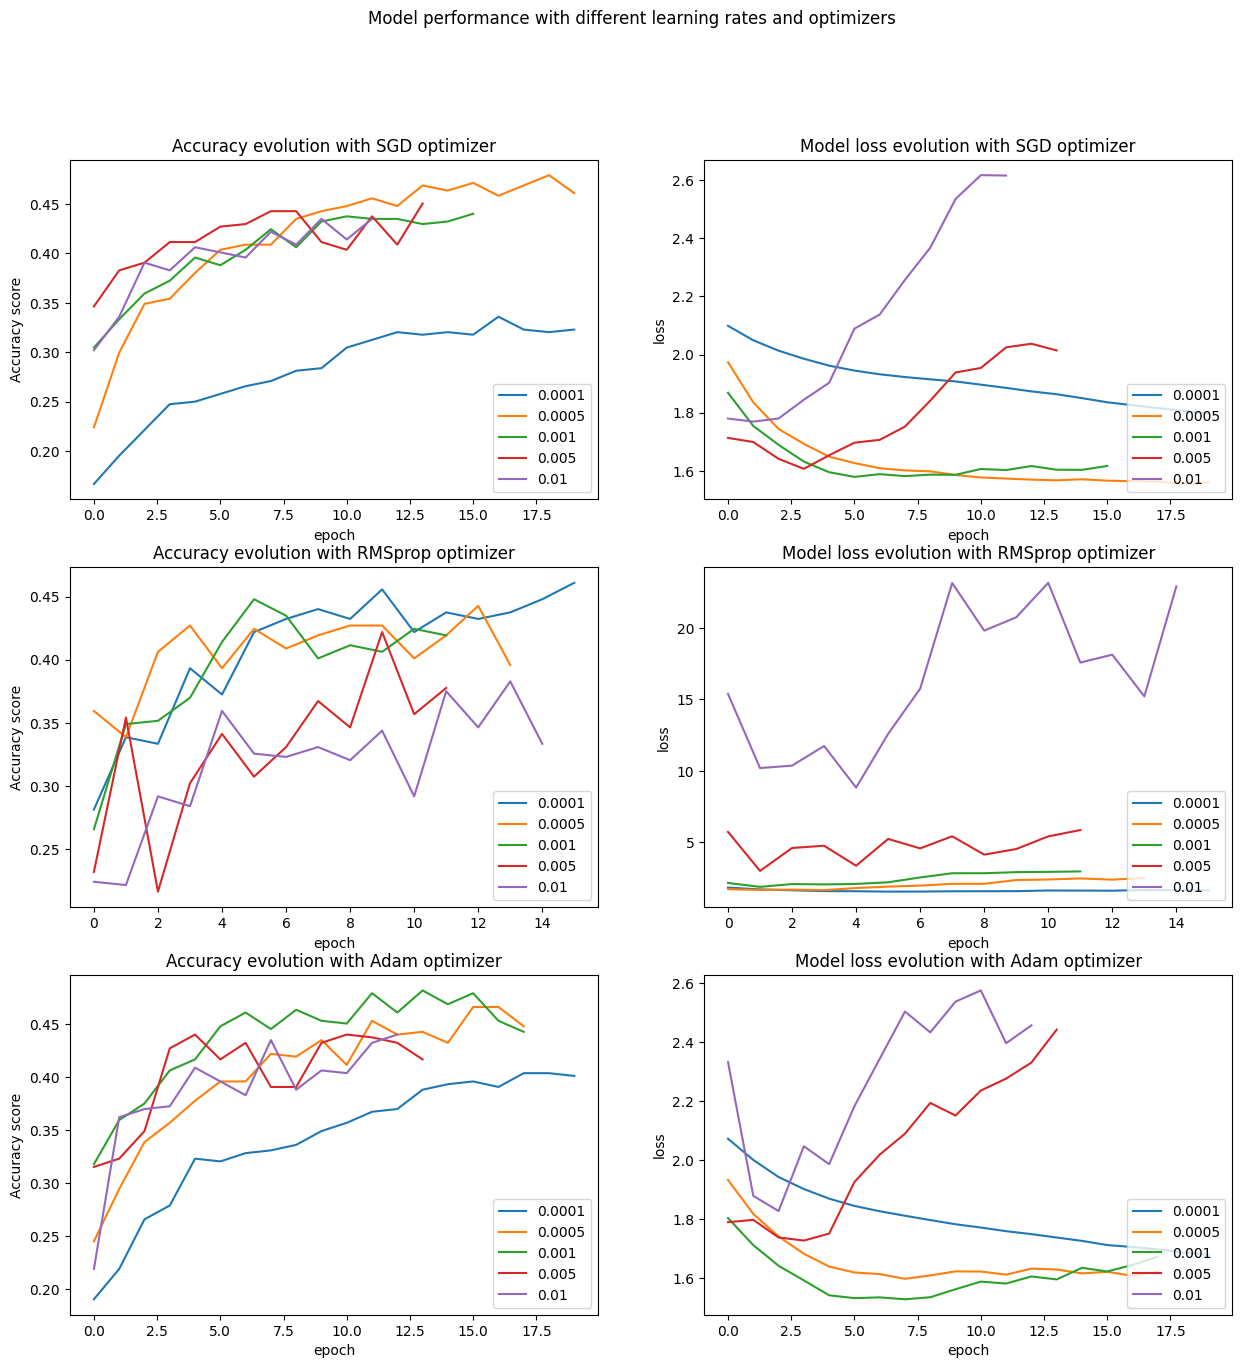

In [ ]:
# Shows parameters evolution

title = 'Model performance with different learning rates and optimizers'
save_picture = True
labels = list(optimizer_dict['Adam']['valid_loss_dict'].keys())
optimizers = ['SGD', 'RMSprop', 'Adam']
row = 0

fig, ax = plt.subplots(3, 2, figsize=(15,15))

for opt in optimizers:
    for lr in labels:
        # Drawing the accuracy
        ax[row, 0].plot(optimizer_dict[opt]['valid_acc_dict'][lr])
        ax[row, 0].title.set_text(f'Accuracy evolution with {opt} optimizer')
        ax[row, 0].set_ylabel(f'Accuracy score')
        ax[row, 0].set_xlabel('epoch')
        ax[row, 0].legend(labels, loc='lower right')

        # Drawing the network error evolucion
        ax[row, 1].plot(optimizer_dict[opt]['valid_loss_dict'][lr])
        ax[row, 1].title.set_text(f'Model loss evolution with {opt} optimizer')
        ax[row, 1].set_ylabel('loss')
        ax[row, 1].set_xlabel('epoch')
        ax[row, 1].legend(labels, loc='lower right')
    row += 1

plt.suptitle(title)
if save_picture == True:
    file_name = title +'.png'
    plt.savefig(os.path.join(metrics_path, file_name), dpi=300)
    print(f'Picture {file_name} saved to disc')
plt.show()

## 4.2 Model 1. Base Model EfficientNet B0. Feature extractor freezed.

We train the model, keeping the feature extractor frozen with the best hyperparameter values obtained in the previous step.

In [22]:
# Base model modification

# Model Parameters
seed = 1234
model_name = "model_ENetB0_1"
n_classes = 8
shape = (224, 224, 3)


# Base model definition
# https://keras.io/api/applications/efficientnet/#efficientnetb1-function

base_model = EfficientNetB0(include_top=False,
                            input_shape=shape,
                            weights="imagenet")
base_model.trainable = False

model_ENetB0_1 = build_model(base_model, n_classes, shape, model_name, seed)
model_ENetB0_1.summary(show_trainable=True)

16705208/16705208 [==============================] - 0s 0us/step
Model: "model_ENetB0_1"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         Y          
                                                                            
 efficientnetb0 (Functional  (None, 7, 7, 1280)        4049571   N          
 )                                                                          
                                                                            
 avg_pool (GlobalAveragePoo  (None, 1280)              0         Y          
 ling2D)                                                                    
                                                                            
 batch_normalization (Batch  (None, 1280)              5120      Y          
 Normalization)                                                 

In [24]:
################################
# Training model EfficienNetB0.1
################################

## Training Parameters
learning_rate = 1e-4
batch_size = 32
epochs = 40
scale = 0 # None
augmentation = True
optimizer = 'adam'
patience = 10
seed = 1234

target_size = (224, 224)
color_mode = 'rgb'

train_path = images_train_path
val_path = images_valid_path
test_path = images_test_path

model_ENetB0_1, model_ENetB0_1_history, valid_generator, test_generator, end_time = trainingTheModel(
    model=model_ENetB0_1,
    train_path=train_path,
    val_path=val_path,
    test_path=test_path,
    type_optimizer = optimizer,
    target_size=target_size,
    color_mode=color_mode,
    learning_rate=learning_rate,
    batch_size=batch_size,
    epochs=epochs,
    augmentation=augmentation,
    patience=patience,
    scale = scale,
    seed=seed
    )

Generating pictures
Found 2400 images belonging to 8 classes.
Found 391 images belonging to 8 classes.
Found 400 images belonging to 8 classes.
Train Step size: 75
Validation Step size: 12
Test Step size: 400
Training the model: model_ENetB0_1. Process Start
----------------------


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/40
75/75 [==============================] - 608s 8s/step - loss: 2.7482 - accuracy: 0.1492 - val_loss: 2.1987 - val_accuracy: 0.1224
Epoch 2/40
75/75 [==============================] - 69s 919ms/step - loss: 2.4974 - accuracy: 0.1787 - val_loss: 2.1423 - val_accuracy: 0.1589
Epoch 3/40
75/75 [==============================] - 69s 921ms/step - loss: 2.3261 - accuracy: 0.2092 - val_loss: 2.0897 - val_accuracy: 0.2135
Epoch 4/40
75/75 [==============================] - 71s 945ms/step - loss: 2.1873 - accuracy: 0.2562 - val_loss: 2.0598 - val_accuracy: 0.2448
Epoch 5/40
75/75 [==============================] - 71s 944ms/step - loss: 2.1085 - accuracy: 0.2604 - val_loss: 2.0219 - val_accuracy: 0.2682
Epoch 6/40
75/75 [==============================] - 71s 949ms/step - loss: 2.0365 - accuracy: 0.2879 - val_loss: 1.9956 - val_accuracy: 0.2865
Epoch 7/40
75/75 [==============================] - 69s 920ms/step - loss: 2.0402 - accuracy: 0.2933 - val_loss: 1.9709 - val_accuracy: 0.2917
E

Picture model_ENetB0_1_model accuray-loss.png saved to disc


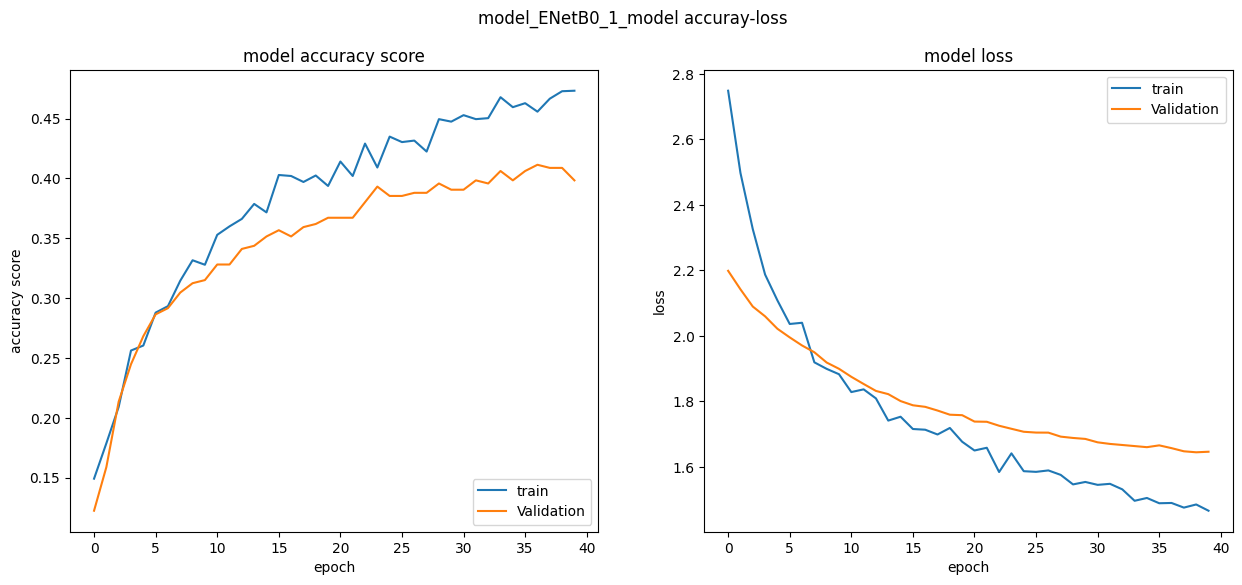

>> Model evaluation
13/13 [==============================] - 6s 476ms/step - loss: 1.6437 - accuracy: 0.3990
Loss: 1.644
Accuracy: 0.399
>> Model prediction
400/400 [==============================] - 98s 239ms/step

>> Metrics calculation


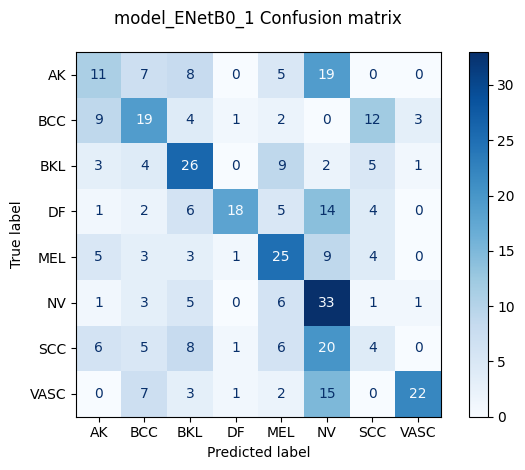

                 AK   BCC       BKL        DF       MEL        NV       SCC  \
precision  0.305556  0.38  0.412698  0.818182  0.416667  0.294643  0.133333   
sensibity  0.220000  0.38  0.520000  0.360000  0.500000  0.660000  0.080000   
f1 score   0.255814  0.38  0.460177  0.500000  0.454545  0.407407  0.100000   

               VASC  
precision  0.814815  
sensibity  0.440000  
f1 score   0.571429  

Model Accuracy: 0.395
Model f1 score: 0.39
Model Precision: 0.45
Model Sensibity: 0.4


<Figure size 640x480 with 0 Axes>

In [25]:
results_model_management(model_ENetB0_1, model_ENetB0_1_history, valid_generator, test_generator, end_time )

In [26]:
# Save the model, weights & history to disc

model_name = model_ENetB0_1.name
model_path = os.path.join(base_path, 'Models', model_name)

model_ENetB0_1.save(os.path.join(model_path,  model_name), save_format='h5')
model_ENetB0_1.save_weights(os.path.join(model_path, model_name + '_weights.h5'))
save_dict_to_disc(model_ENetB0_1_history.history, os.path.join(model_path, model_name + '_history') )

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## 4.3 Model 1.2. Base Model EfficientNet B0. Unfreeze extractor features last layers


A new model, identical to the previous one, is created, but the last convolutional block of the base model is removed. The weights from the previous training are applied to it.

In [ ]:
model_ENetB0_1 = load_model(os.path.join(base_path, 'Models', 'model_ENetB0_1','model_ENetB0_1' + '.h5'))

In [27]:
#Model achitecture parameters
shape = (224, 224, 3)
n_classes = 8
model_name = 'model_ENetB0_2'
seed = 1234

model_path = os.path.join(base_path, 'Models', model_name)

# Base model
base_model = EfficientNetB0(include_top=False,
                           input_shape=shape,
                           weights="imagenet")

In [ ]:
# How layers unfreezed to cover a convolutional block?

print('Model layers')
n = 0
for layer in model_ENetB0_1.layers:
    print(n, ' - ', layer.name)
    n += 1
print()
print('Base model layers')
for i in range(17, 0, -1):
    print(i, ' - ', base_model.layers[-i].name)

Model layers
0  -  input_layer
1  -  efficientnetb0
2  -  avg_pool
3  -  batch_normalization
4  -  top_dropout
5  -  pred

Base model layers
17  -  block6d_add
16  -  block7a_expand_conv
15  -  block7a_expand_bn
14  -  block7a_expand_activation
13  -  block7a_dwconv
12  -  block7a_bn
11  -  block7a_activation
10  -  block7a_se_squeeze
9  -  block7a_se_reshape
8  -  block7a_se_reduce
7  -  block7a_se_expand
6  -  block7a_se_excite
5  -  block7a_project_conv
4  -  block7a_project_bn
3  -  top_conv
2  -  top_bn
1  -  top_activation


The total number of layers to be trained is 20. Base model Conv7 block is formed for 16 layers more 4 from the classification layers.

In [28]:
# Parameter
num_layers_unfreeze = 20

# Freeze the base model until last convolutional block
for layer in base_model.layers[: - num_layers_unfreeze]:
    layer.trainable = False

modelENetB0_2 = build_model(base_model, n_classes, shape, model_name, seed)

# We ensure that batchNormalization layers are not trainable.
for layer in modelENetB0_2.layers[:]:
    if isinstance(layer, layers.BatchNormalization):
        layer.trainable = False


# Transfer learning
#model1 = load_model(os.path.join(base_path, 'Models', 'model1','model1'))
weights_model1 = model_ENetB0_1.get_weights()
modelENetB0_2.set_weights = weights_model1

modelENetB0_2.summary(show_trainable=True)

Model: "model_ENetB0_2"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         Y          
                                                                            
 efficientnetb0 (Functional  (None, 7, 7, 1280)        4049571   Y          
 )                                                                          
                                                                            
 avg_pool (GlobalAveragePoo  (None, 1280)              0         Y          
 ling2D)                                                                    
                                                                            
 batch_normalization_1 (Bat  (None, 1280)              5120      N          
 chNormalization)                                                           
                                                    

In [29]:
###################################
# Training model EfficientNetB0.2
###################################

## Training Parameters
learning_rate = 1e-4
batch_size = 32
epochs = 8
scale = 0 # None
augmentation = True
optimizer = 'adam'
patience = 10
seed = 1234

target_size = (224, 224)
color_mode = 'rgb'

train_path = images_train_path
val_path = images_valid_path
test_path = images_test_path

modelENetB0_2, modelENetB0_2_history, valid_generator, test_generator, end_time = trainingTheModel(
    model=modelENetB0_2,
    train_path=train_path,
    val_path=val_path,
    test_path=test_path,
    type_optimizer = optimizer,
    target_size=target_size,
    color_mode=color_mode,
    learning_rate=learning_rate,
    batch_size=batch_size,
    epochs=epochs,
    augmentation=augmentation,
    patience=patience,
    scale = scale,
    seed=seed
    )

Generating pictures
Found 2400 images belonging to 8 classes.
Found 391 images belonging to 8 classes.
Found 400 images belonging to 8 classes.
Train Step size: 75
Validation Step size: 12
Test Step size: 400
Training the model: model_ENetB0_2. Process Start
----------------------


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/8
75/75 [==============================] - 82s 936ms/step - loss: 1.9657 - accuracy: 0.2429 - val_loss: 1.8050 - val_accuracy: 0.3073
Epoch 2/8
75/75 [==============================] - 68s 902ms/step - loss: 1.6691 - accuracy: 0.3742 - val_loss: 1.6135 - val_accuracy: 0.3672
Epoch 3/8
75/75 [==============================] - 76s 1s/step - loss: 1.4957 - accuracy: 0.4412 - val_loss: 1.5337 - val_accuracy: 0.4115
Epoch 4/8
75/75 [==============================] - 80s 1s/step - loss: 1.4294 - accuracy: 0.4642 - val_loss: 1.4804 - val_accuracy: 0.4505
Epoch 5/8
75/75 [==============================] - 79s 1s/step - loss: 1.3597 - accuracy: 0.5079 - val_loss: 1.4632 - val_accuracy: 0.4505
Epoch 6/8
75/75 [==============================] - 68s 912ms/step - loss: 1.3031 - accuracy: 0.5371 - val_loss: 1.4421 - val_accuracy: 0.4714
Epoch 7/8
75/75 [==============================] - 73s 969ms/step - loss: 1.2427 - accuracy: 0.5579 - val_loss: 1.4261 - val_accuracy: 0.4818
Epoch 8/8
75/75

Picture model_ENetB0_2_model accuray-loss.png saved to disc


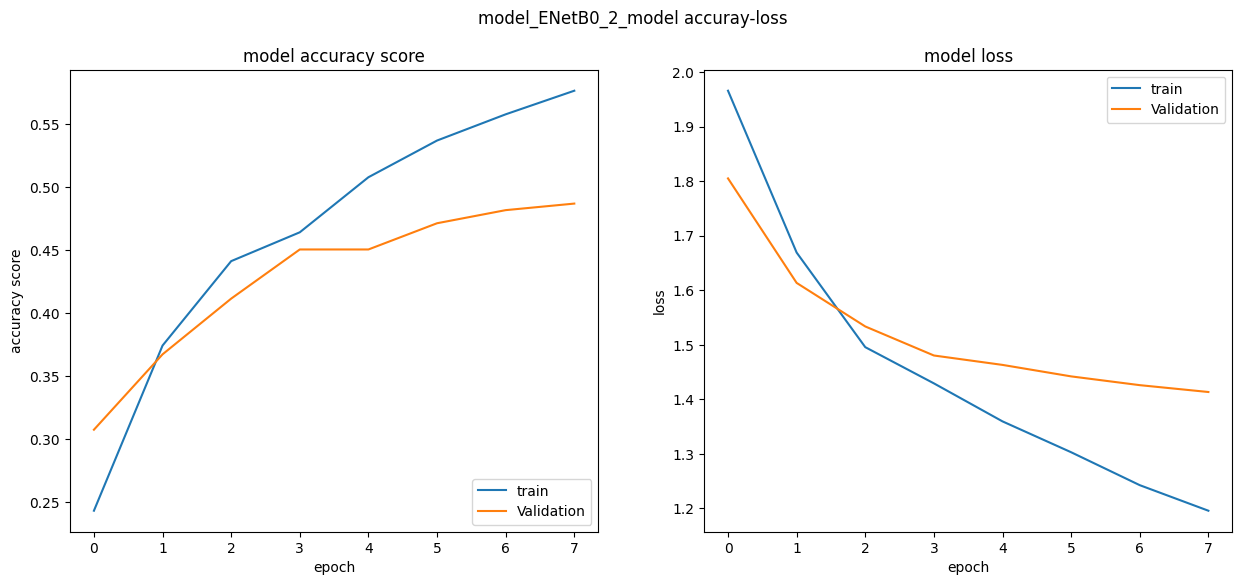

>> Model evaluation
13/13 [==============================] - 5s 396ms/step - loss: 1.4027 - accuracy: 0.4910
Loss: 1.403
Accuracy: 0.491
>> Model prediction
400/400 [==============================] - 9s 18ms/step

>> Metrics calculation


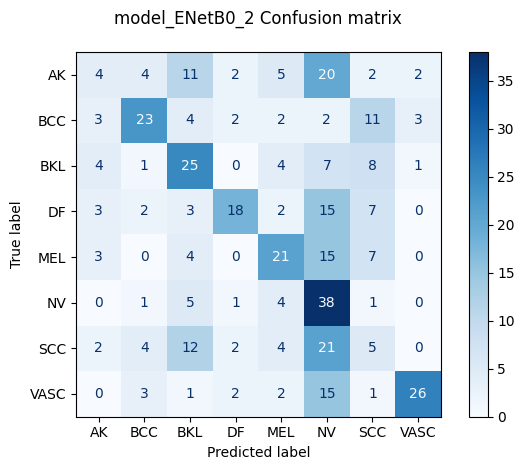

                 AK       BCC       BKL        DF       MEL        NV  \
precision  0.210526  0.605263  0.384615  0.666667  0.477273  0.285714   
sensibity  0.080000  0.460000  0.500000  0.360000  0.420000  0.760000   
f1 score   0.115942  0.522727  0.434783  0.467532  0.446809  0.415301   

                SCC      VASC  
precision  0.119048  0.812500  
sensibity  0.100000  0.520000  
f1 score   0.108696  0.634146  

Model Accuracy: 0.4
Model f1 score: 0.39
Model Precision: 0.45
Model Sensibity: 0.4


<Figure size 640x480 with 0 Axes>

In [30]:
results_model_management(modelENetB0_2, modelENetB0_2_history, valid_generator, test_generator, end_time )

In [31]:
# Save the model, weights & history to disc

model_name = modelENetB0_2.name

modelENetB0_2.save(os.path.join(model_path,  model_name), save_format='h5')
modelENetB0_2.save_weights(os.path.join(model_path, model_name + '_weights.h5'))
save_dict_to_disc(modelENetB0_2_history.history, os.path.join(model_path, model_name + '_history') )

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## 4.4 Model 3. Base Model EfficientNet B0. Training all layers

Starting with the weights from model 2, all layers are unfrozen and the entire network is trained.

In [32]:
#Model achitecture parameters
shape = (224, 224, 3)
n_classes = 8
model_name = 'model_ENetB0_3'
num_layers_unfreeze = 20
seed = 1234

model_path = os.path.join(base_path, 'Models', model_name)

# Base model
base_model = EfficientNetB0(include_top=False,
                           input_shape=shape,
                           weights="imagenet")

modelENetB0_3 = build_model(base_model, n_classes, shape, model_name, seed)

# Model 2 Restore & extract its weights

modelENetB0_2 = load_model(os.path.join(base_path, 'Models', 'model_ENetB0_2','model_ENetB0_2'), compile = False)
weights_model = modelENetB0_2.get_weights()

# Unfreeze the whole model except batchNormalization layers
for layer in modelENetB0_3.layers[: - num_layers_unfreeze]:
    if not isinstance(layer, layers.BatchNormalization):
        layer.trainable = True

# Transfer learning
modelENetB0_3.set_weights = weights_model

modelENetB0_3.summary(show_trainable=True)

Model: "model_ENetB0_3"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         Y          
                                                                            
 efficientnetb0 (Functional  (None, 7, 7, 1280)        4049571   Y          
 )                                                                          
                                                                            
 avg_pool (GlobalAveragePoo  (None, 1280)              0         Y          
 ling2D)                                                                    
                                                                            
 batch_normalization_2 (Bat  (None, 1280)              5120      Y          
 chNormalization)                                                           
                                                    

In [33]:
###################################
# Training model  EfficientNetB0.3
###################################

## Training Parameters
learning_rate = 1e-5
batch_size = 32
epochs = 40
scale = 0 # None
augmentation = True
optimizer = 'adam'
patience = 10
seed = 1234

target_size = (224, 224)
color_mode = 'rgb'

train_path = images_train_path
val_path = images_valid_path
test_path = images_test_path

modelENetB0_3, modelENetB0_3_history, valid_generator, test_generator, end_time = trainingTheModel(
    model=modelENetB0_3,
    train_path=train_path,
    val_path=val_path,
    test_path=test_path,
    type_optimizer = optimizer,
    target_size=target_size,
    color_mode=color_mode,
    learning_rate=learning_rate,
    batch_size=batch_size,
    epochs=epochs,
    augmentation=augmentation,
    patience=patience,
    scale = scale,
    seed=seed
    )

Generating pictures
Found 2400 images belonging to 8 classes.
Found 391 images belonging to 8 classes.
Found 400 images belonging to 8 classes.
Train Step size: 75
Validation Step size: 12
Test Step size: 400
Training the model: model_ENetB0_3. Process Start
----------------------


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/40
75/75 [==============================] - 123s 1s/step - loss: 2.7116 - accuracy: 0.1496 - val_loss: 2.1403 - val_accuracy: 0.1797
Epoch 2/40
75/75 [==============================] - 73s 972ms/step - loss: 2.3768 - accuracy: 0.2129 - val_loss: 2.0952 - val_accuracy: 0.2292
Epoch 3/40
75/75 [==============================] - 73s 969ms/step - loss: 2.2365 - accuracy: 0.2421 - val_loss: 2.0351 - val_accuracy: 0.2812
Epoch 4/40
75/75 [==============================] - 72s 962ms/step - loss: 2.0297 - accuracy: 0.2921 - val_loss: 1.9736 - val_accuracy: 0.3073
Epoch 5/40
75/75 [==============================] - 79s 1s/step - loss: 1.9139 - accuracy: 0.3471 - val_loss: 1.8912 - val_accuracy: 0.3281
Epoch 6/40
75/75 [==============================] - 72s 962ms/step - loss: 1.8289 - accuracy: 0.3583 - val_loss: 1.8350 - val_accuracy: 0.3646
Epoch 7/40
75/75 [==============================] - 72s 961ms/step - loss: 1.8020 - accuracy: 0.3667 - val_loss: 1.8022 - val_accuracy: 0.3724
Epoc

The training ends around the 40th epoch. Overfitting appears after this epoch.

Picture model_ENetB0_3_model accuray-loss.png saved to disc


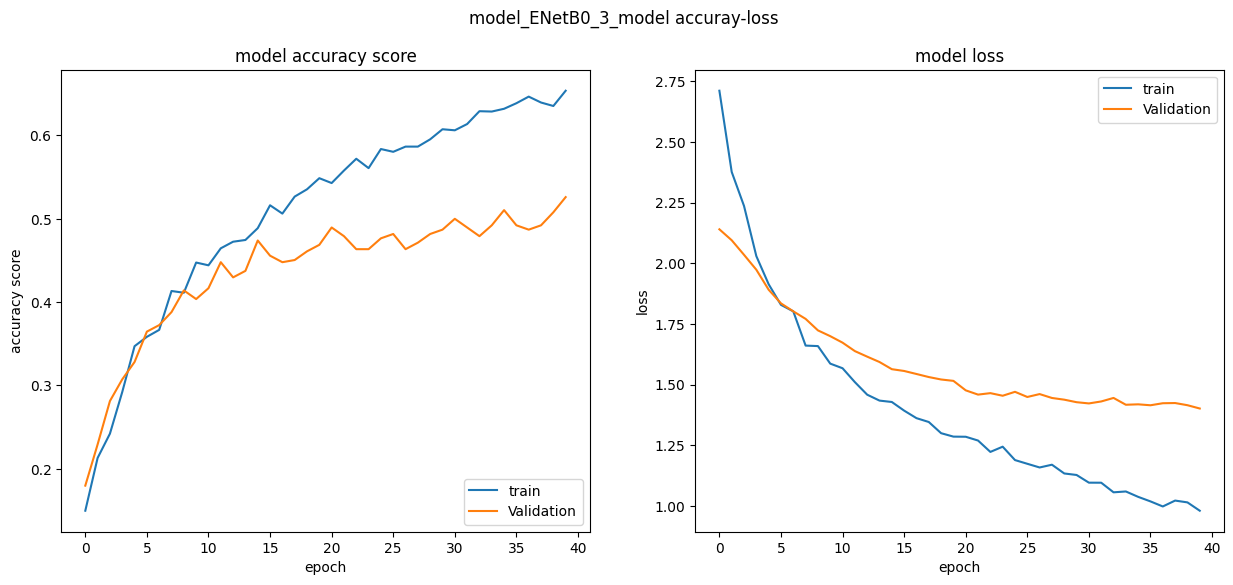

>> Model evaluation
13/13 [==============================] - 6s 473ms/step - loss: 1.3848 - accuracy: 0.5345
Loss: 1.385
Accuracy: 0.535
>> Model prediction
400/400 [==============================] - 8s 16ms/step

>> Metrics calculation


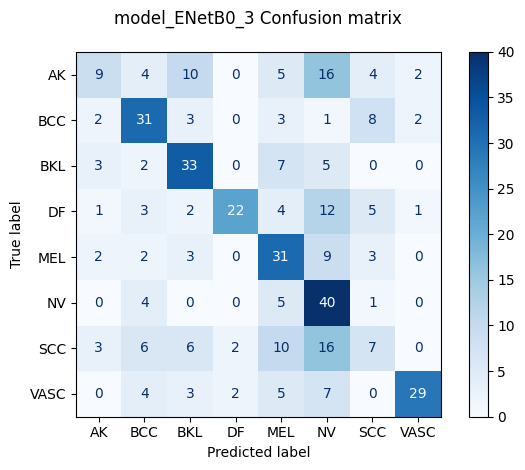

                 AK       BCC   BKL        DF       MEL        NV       SCC  \
precision  0.450000  0.553571  0.55  0.846154  0.442857  0.377358  0.250000   
sensibity  0.180000  0.620000  0.66  0.440000  0.620000  0.800000  0.140000   
f1 score   0.257143  0.584906  0.60  0.578947  0.516667  0.512821  0.179487   

               VASC  
precision  0.852941  
sensibity  0.580000  
f1 score   0.690476  

Model Accuracy: 0.505
Model f1 score: 0.49
Model Precision: 0.54
Model Sensibity: 0.5


<Figure size 640x480 with 0 Axes>

In [34]:
results_model_management(modelENetB0_3, modelENetB0_3_history, valid_generator, test_generator, end_time )

In [35]:
# Save the model, weights & history to disc

model_name = modelENetB0_3.name

modelENetB0_3.save(os.path.join(model_path,  model_name), save_format='h5')
modelENetB0_3.save_weights(os.path.join(model_path, model_name + '_weights.h5'))
save_dict_to_disc(modelENetB0_3_history.history, os.path.join(model_path, model_name + '_history') )

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


 # 5 - Transfern Learning with ResNet50

For our model 4 we have chosen to train a ResNet50. Compared to the EfficientNetB0 used in the previous models tested, ResNet increases the number of parameters by a factor of 5 to 25.6M.

https://keras.io/api/applications/

https://keras.io/api/applications/#usage-examples-for-image-classification-models

The input configuration (input_shape) has to continue with the same format (224, 224, 3), and includes an additional pooling mode, which can be enabled when operated as a feature extractor.

## 5.1 Hyperparameters Search

In [36]:
#Model achitecture parameters
shape = (224, 224, 3)
n_classes = 8
model_name = 'model_RNet1'
seed = 1234

model_path = os.path.join(base_path, 'Models', model_name)

# Base model
base_model = ResNet50V2(weights = 'imagenet',
                       include_top = False,
                       input_shape = shape)
base_model.trainable = False

model = build_model(base_model, n_classes, shape, model_name, seed)

model.summary(show_trainable=True)

94668760/94668760 [==============================] - 1s 0us/step
Model: "model_RNet1"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         Y          
                                                                            
 resnet50v2 (Functional)     (None, 7, 7, 2048)        2356480   N          
                                                       0                    
                                                                            
 avg_pool (GlobalAveragePoo  (None, 2048)              0         Y          
 ling2D)                                                                    
                                                                            
 batch_normalization_3 (Bat  (None, 2048)              8192      Y          
 chNormalization)                                                  

In [37]:
############################################
# Model RNet Searching hyperparameters Step
############################################

# Fix Training Parameters
batch_size = 32
epochs = 20
augmentation = False
scale = 2 # [-1, 1] rescale
seed = 1234
target_size = (224, 224)
color_mode = 'rgb'

# Variables Training Parameters
learning_rate = [1e-4, 5e-4, 1e-3, 5e-3, 1e-2]
optimizer = ['Adam', 'SGD']
# learning_rate = [1e-3, 1e-2]
# optimizer = ['Adam']

optimizer_dict = dict()
valid_loss_dict = dict()
valid_acc_dict = dict()
time_dict = dict()

# Path images
train_path = images_train_path
val_path = images_valid_path
test_path = images_test_path

# Data augmentation config
train_generator, valid_generator, test_generator = image_generator(
    train_path=train_path,
    val_path=val_path,
    test_path=test_path,
    target_size=target_size,
    batch_size=batch_size,
    color_mode=color_mode,
    augmentation = augmentation,
    scale=scale)

STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n // valid_generator.batch_size
STEP_SIZE_TEST = test_generator.n // test_generator.batch_size

print(f'Train Step size: {STEP_SIZE_TRAIN}')
print(f'Validation Step size: {STEP_SIZE_VALID}')
print(f'Test Step size: {STEP_SIZE_TEST}')

# Callback definition:
es = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 10)

n = 0

print('The search for hyperparameters has begun')
print('=========================================')
for opt in optimizer:
    print(f'Optimizer: {opt}')
    print('----------')
    for lr in learning_rate:
        model = build_model(base_model, n_classes, shape, model_name, seed)
        print(f'Learning Rate {lr}')

        if opt == 'Adam':
            optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
        elif opt == 'SGD':
            optimizer = tf.keras.optimizers.SGD(learning_rate=lr)

        # Model compilation
        model.compile(
            optimizer=optimizer,
            loss="categorical_crossentropy",
            metrics=['accuracy']
        )

        # Training the model
        print('>> Training process Start')

        # Time started
        start_time = time.time()

        model_history = model.fit(
            train_generator,
            steps_per_epoch=STEP_SIZE_TRAIN,
            validation_data=valid_generator,
            validation_steps=STEP_SIZE_VALID,
            epochs=epochs,
            callbacks=[es, TqdmCallback(verbose=1)]
            )

        end_time = time.time() - start_time

        # Storage the accuracy score and loss for each learning rate value
        valid_loss_dict[lr] = model_history.history['val_loss']
        valid_acc_dict[lr] = model_history.history['val_accuracy']
        time_dict[lr] = end_time

        # Calculating the main indicators
        print('>> The Training has finished')
        print(f'Time execution: {end_time}')
        print('--------------')
        del model # Used for ensure the garbage out
        del model_history
        n += 1
    optimizer_dict[opt] = {'valid_loss_dict': valid_loss_dict,
                           'valid_acc_dict': valid_acc_dict,
                           'lr': learning_rate,
                           'time': time_dict
                           }

    valid_loss_dict = dict()
    valid_acc_dict = dict()
    time_dict = dict()
    n = 0
print('>> Hyperparameters search completed')

TypeError: ignored

In [ ]:
# Save the best parameters to disc

file_name = 'hyparameters_search_result_model_ResNet50'
save_dict_to_disc(optimizer_dict, os.path.join(metrics_path, file_name) )

Picture ResNet50 Model performance with different learning rates and optimizers.png saved to disc


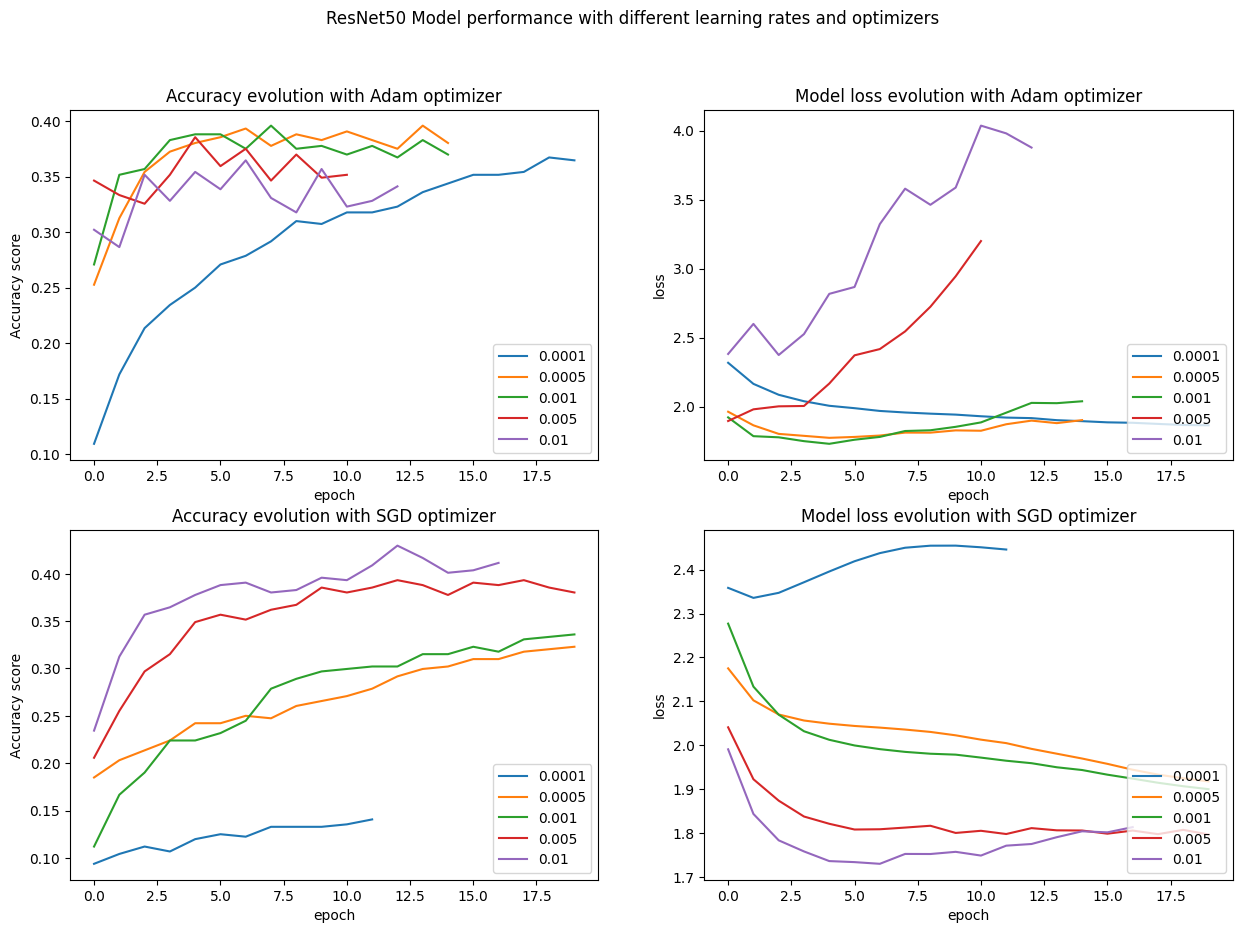

In [ ]:
# Shows parameters evolution

title = 'ResNet50 Model performance with different learning rates and optimizers'
save_picture = True
labels = list(optimizer_dict['Adam']['valid_loss_dict'].keys())

optimizers = ['Adam', 'SGD']
row = 0

fig, ax = plt.subplots(2, 2, figsize=(15,10))

for opt in optimizers:
    for lr in labels:
        # Drawing the accuracy
        ax[row, 0].plot(optimizer_dict[opt]['valid_acc_dict'][lr])
        ax[row, 0].title.set_text(f'Accuracy evolution with {opt} optimizer')
        ax[row, 0].set_ylabel(f'Accuracy score')
        ax[row, 0].set_xlabel('epoch')
        ax[row, 0].legend(labels, loc='lower right')

        # Drawing the network error evolucion
        ax[row, 1].plot(optimizer_dict[opt]['valid_loss_dict'][lr])
        ax[row, 1].title.set_text(f'Model loss evolution with {opt} optimizer')
        ax[row, 1].set_ylabel('loss')
        ax[row, 1].set_xlabel('epoch')
        ax[row, 1].legend(labels, loc='lower right')
    row += 1

plt.suptitle(title)
if save_picture == True:
    file_name = title +'.png'
    plt.savefig(os.path.join(metrics_path, file_name), dpi=300)
    print(f'Picture {file_name} saved to disc')
plt.show()

## 5.2 ResNet50 Model. Feature Extractor freezed

In [38]:
#Model achitecture parameters
shape = (224, 224, 3)
n_classes = 8
model_name = 'model_RNet1'
seed = 1234

model_path = os.path.join(base_path, 'Models', model_name)

# Base model
base_model = ResNet50V2(weights = 'imagenet',
                       include_top = False,
                       input_shape = shape)
base_model.trainable = False

model = build_model(base_model, n_classes, shape, model_name, seed)

model.summary(show_trainable=True)

Model: "model_RNet1"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         Y          
                                                                            
 resnet50v2 (Functional)     (None, 7, 7, 2048)        2356480   N          
                                                       0                    
                                                                            
 avg_pool (GlobalAveragePoo  (None, 2048)              0         Y          
 ling2D)                                                                    
                                                                            
 batch_normalization_4 (Bat  (None, 2048)              8192      Y          
 chNormalization)                                                           
                                                       

In [39]:
#######################
# Training model RNet1
#######################

## Training Parameters
learning_rate = 1e-4
batch_size = 32
epochs = 30
scale = 2 # [-1, 1] rescale
optimizer = 'adam'
augmentation = True
patience = 10
seed = 1234

target_size = (224, 224)
color_mode = 'rgb'

train_path = images_train_path
val_path = images_valid_path
test_path = images_test_path

modelRN1, modelRN1_history, valid_generator, test_generator, end_time = trainingTheModel(
    model=model,
    train_path=train_path,
    val_path=val_path,
    test_path=test_path,
    type_optimizer = optimizer,
    target_size=target_size,
    color_mode=color_mode,
    learning_rate=learning_rate,
    batch_size=batch_size,
    epochs=epochs,
    augmentation=augmentation,
    patience=patience,
    scale = scale,
    seed=seed
    )

Generating pictures
Found 2400 images belonging to 8 classes.
Found 391 images belonging to 8 classes.
Found 400 images belonging to 8 classes.
Train Step size: 75
Validation Step size: 12
Test Step size: 400
Training the model: model_RNet1. Process Start
----------------------


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/30
75/75 [==============================] - 80s 986ms/step - loss: 2.6241 - accuracy: 0.1450 - val_loss: 2.2036 - val_accuracy: 0.1641
Epoch 2/30
75/75 [==============================] - 70s 934ms/step - loss: 2.5026 - accuracy: 0.1762 - val_loss: 2.1271 - val_accuracy: 0.1849
Epoch 3/30
75/75 [==============================] - 77s 1s/step - loss: 2.3359 - accuracy: 0.1992 - val_loss: 2.0940 - val_accuracy: 0.2240
Epoch 4/30
75/75 [==============================] - 73s 970ms/step - loss: 2.2742 - accuracy: 0.2229 - val_loss: 2.0782 - val_accuracy: 0.2240
Epoch 5/30
75/75 [==============================] - 70s 936ms/step - loss: 2.2194 - accuracy: 0.2221 - val_loss: 2.0623 - val_accuracy: 0.2344
Epoch 6/30
75/75 [==============================] - 70s 928ms/step - loss: 2.1634 - accuracy: 0.2525 - val_loss: 2.0512 - val_accuracy: 0.2422
Epoch 7/30
75/75 [==============================] - 76s 1s/step - loss: 2.0967 - accuracy: 0.2596 - val_loss: 2.0287 - val_accuracy: 0.2422
Epoch

Picture model_RNet1_model accuray-loss.png saved to disc


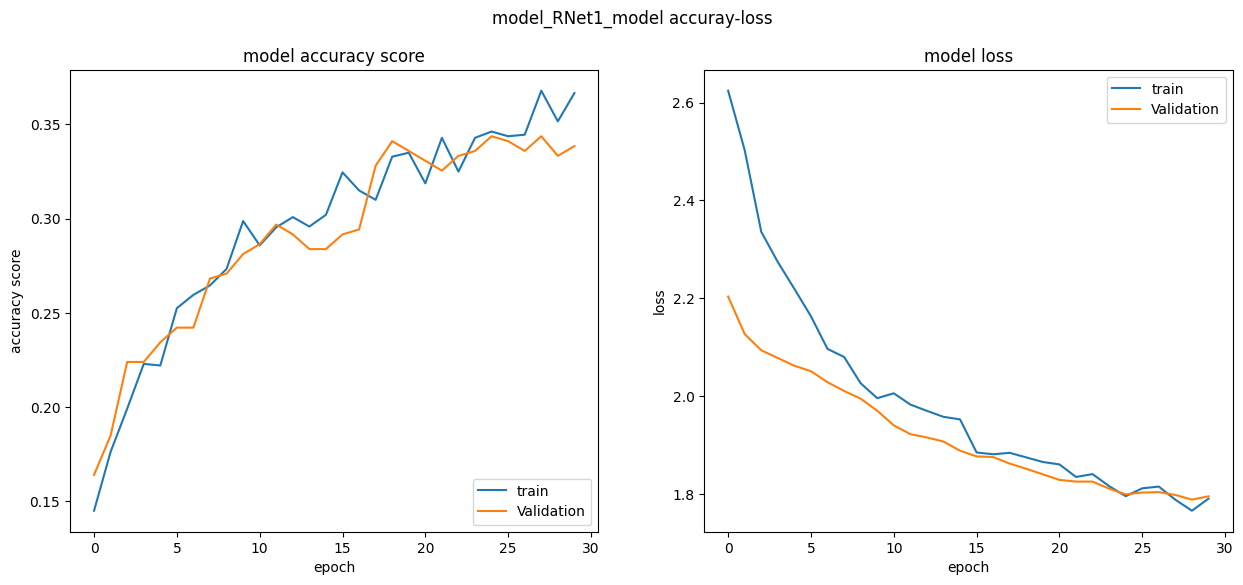

>> Model evaluation
13/13 [==============================] - 6s 467ms/step - loss: 1.7904 - accuracy: 0.3402
Loss: 1.790
Accuracy: 0.340
>> Model prediction
400/400 [==============================] - 10s 21ms/step

>> Metrics calculation


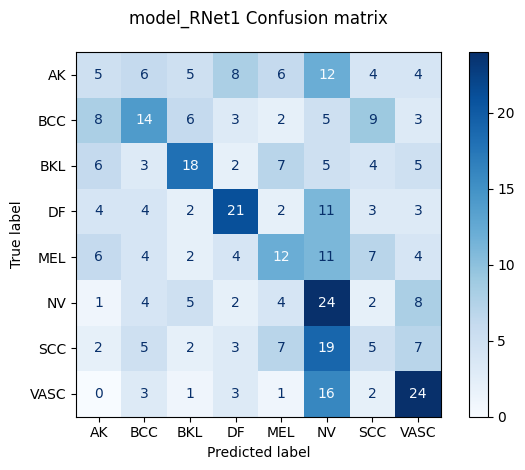

                 AK       BCC       BKL        DF       MEL        NV  \
precision  0.156250  0.325581  0.439024  0.456522  0.292683  0.233010   
sensibity  0.100000  0.280000  0.360000  0.420000  0.240000  0.480000   
f1 score   0.121951  0.301075  0.395604  0.437500  0.263736  0.313725   

                SCC      VASC  
precision  0.138889  0.413793  
sensibity  0.100000  0.480000  
f1 score   0.116279  0.444444  

Model Accuracy: 0.3075
Model f1 score: 0.3
Model Precision: 0.31
Model Sensibity: 0.31


<Figure size 640x480 with 0 Axes>

In [40]:
results_model_management(modelRN1, modelRN1_history, valid_generator, test_generator, end_time )

In [41]:
# Save the model, weights & history to disc

saveModelParameters(model_path, modelRN1, modelRN1_history)


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model parameters have been saved.
/content/drive/MyDrive/Colab Notebooks/Master UOC/TFM/Dermatological lesion classification/Data/Models/model_RNet1/model_RNet1


## 5.3 ResNet50 Model. Unfreeze Extractor features last layers

In [42]:
# How layers unfreezed to cover a convolutional block?

print('Model layers')
n = 0
for layer in modelRN1.layers:
    print(n, ' - ', layer.name)
    n += 1
print()
print('Base model layers')
for i in range(37, 0, -1):
    print(i, ' - ', base_model.layers[-i].name)




Model layers
0  -  input_layer
1  -  resnet50v2
2  -  avg_pool
3  -  batch_normalization_4
4  -  top_dropout
5  -  pred

Base model layers
37  -  conv4_block6_out
36  -  conv5_block1_preact_bn
35  -  conv5_block1_preact_relu
34  -  conv5_block1_1_conv
33  -  conv5_block1_1_bn
32  -  conv5_block1_1_relu
31  -  conv5_block1_2_pad
30  -  conv5_block1_2_conv
29  -  conv5_block1_2_bn
28  -  conv5_block1_2_relu
27  -  conv5_block1_0_conv
26  -  conv5_block1_3_conv
25  -  conv5_block1_out
24  -  conv5_block2_preact_bn
23  -  conv5_block2_preact_relu
22  -  conv5_block2_1_conv
21  -  conv5_block2_1_bn
20  -  conv5_block2_1_relu
19  -  conv5_block2_2_pad
18  -  conv5_block2_2_conv
17  -  conv5_block2_2_bn
16  -  conv5_block2_2_relu
15  -  conv5_block2_3_conv
14  -  conv5_block2_out
13  -  conv5_block3_preact_bn
12  -  conv5_block3_preact_relu
11  -  conv5_block3_1_conv
10  -  conv5_block3_1_bn
9  -  conv5_block3_1_relu
8  -  conv5_block3_2_pad
7  -  conv5_block3_2_conv
6  -  conv5_block3_2_bn
5

The total number of layers to be trained is 40. Base model Conv5 block is formed for 36 layers more 4 from the classification layers.

In [43]:
#Model achitecture parameters
shape = (224, 224, 3)
n_classes = 8
model_name = 'model_RNet2'
num_layers_unfreeze = 40
seed = 1234

model_path = os.path.join(base_path, 'Models', model_name)


# Base model
base_model = ResNet50V2(weights = 'imagenet',
                       include_top = False,
                       input_shape = shape)

# Freeze the base model until last convolutional block
for layer in base_model.layers[: - num_layers_unfreeze]:
    layer.trainable = False

modelRN2 = build_model(base_model, n_classes, shape, model_name, seed)

# We ensure that batchNormalization layers are not trainable.
for layer in modelRN2.layers[:]:
    if isinstance(layer, layers.BatchNormalization):
        layer.trainable = False

# Transfer learning
modelRN1 = load_model(os.path.join(base_path, 'Models', 'model_RNet1','model_RNet1'))
weights_model = modelRN1.get_weights()
modelRN2.set_weights = weights_model

modelRN2.summary(show_trainable=True)

Model: "model_RNet2"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         Y          
                                                                            
 resnet50v2 (Functional)     (None, 7, 7, 2048)        2356480   Y          
                                                       0                    
                                                                            
 avg_pool (GlobalAveragePoo  (None, 2048)              0         Y          
 ling2D)                                                                    
                                                                            
 batch_normalization_5 (Bat  (None, 2048)              8192      N          
 chNormalization)                                                           
                                                       

In [44]:
###################
# Training model RN2
###################

## Training Parameters
learning_rate = 1e-4
batch_size = 32
epochs = 5
augmentation = False
optimizer = 'adam'
patience = 10
scale = 2 # [-1, 1] rescale
seed = 1234

target_size = (224, 224)
color_mode = 'rgb'

train_path = images_train_path
val_path = images_valid_path
test_path = images_test_path

modelRN2, modelRN2_history, valid_generator, test_generator, end_time = trainingTheModel(
    model=modelRN2,
    train_path=train_path,
    val_path=val_path,
    test_path=test_path,
    type_optimizer = optimizer,
    target_size=target_size,
    color_mode=color_mode,
    learning_rate=learning_rate,
    batch_size=batch_size,
    epochs=epochs,
    augmentation=augmentation,
    scale=scale,
    patience=patience,
    seed=seed
    )

Generating pictures
Found 2400 images belonging to 8 classes.
Found 391 images belonging to 8 classes.
Found 400 images belonging to 8 classes.
Train Step size: 75
Validation Step size: 12
Test Step size: 400
Training the model: model_RNet2. Process Start
----------------------


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/5
75/75 [==============================] - 53s 572ms/step - loss: 1.9796 - accuracy: 0.2483 - val_loss: 1.8192 - val_accuracy: 0.3281
Epoch 2/5
75/75 [==============================] - 42s 554ms/step - loss: 1.6117 - accuracy: 0.4200 - val_loss: 1.6008 - val_accuracy: 0.4115
Epoch 3/5
75/75 [==============================] - 37s 486ms/step - loss: 1.2942 - accuracy: 0.5267 - val_loss: 1.6596 - val_accuracy: 0.3906
Epoch 4/5
75/75 [==============================] - 37s 493ms/step - loss: 0.9749 - accuracy: 0.6475 - val_loss: 1.5867 - val_accuracy: 0.4661
Epoch 5/5
75/75 [==============================] - 36s 486ms/step - loss: 0.6090 - accuracy: 0.7854 - val_loss: 1.8033 - val_accuracy: 0.4427
Training Process finished
-------------------------
Time Execution: 210.1618459224701 sec.


Picture model_RNet2_model accuray-loss.png saved to disc


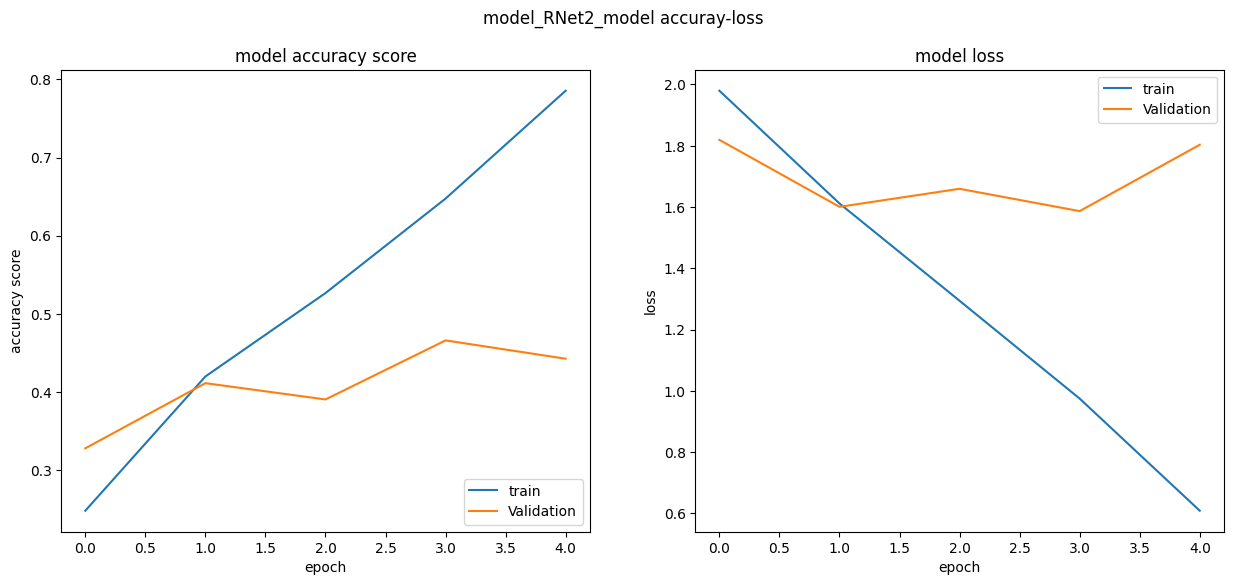

>> Model evaluation
13/13 [==============================] - 5s 362ms/step - loss: 1.8114 - accuracy: 0.4425
Loss: 1.811
Accuracy: 0.442
>> Model prediction
400/400 [==============================] - 9s 21ms/step

>> Metrics calculation


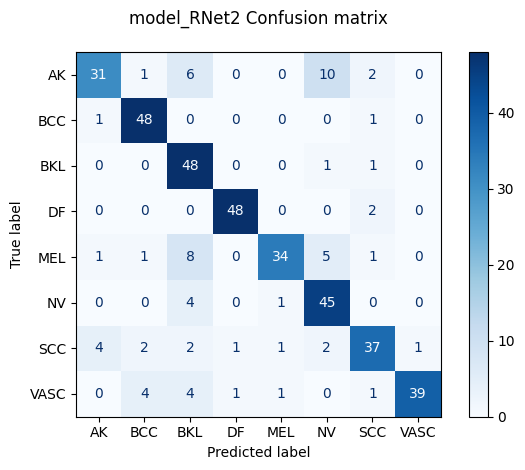

                 AK       BCC       BKL    DF       MEL        NV       SCC  \
precision  0.837838  0.857143  0.666667  0.96  0.918919  0.714286  0.822222   
sensibity  0.620000  0.960000  0.960000  0.96  0.680000  0.900000  0.740000   
f1 score   0.712644  0.905660  0.786885  0.96  0.781609  0.796460  0.778947   

               VASC  
precision  0.975000  
sensibity  0.780000  
f1 score   0.866667  

Model Accuracy: 0.825
Model f1 score: 0.82
Model Precision: 0.84
Model Sensibity: 0.82


<Figure size 640x480 with 0 Axes>

In [45]:
results_model_management(modelRN2, modelRN2_history, valid_generator, test_generator, end_time )

In [46]:
# Save the model, weights & history to disc

saveModelParameters(model_path, modelRN2, modelRN2_history)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model parameters have been saved.
/content/drive/MyDrive/Colab Notebooks/Master UOC/TFM/Dermatological lesion classification/Data/Models/model_RNet2/model_RNet2


## 5.4 ResNet50 Model. Training all layers

In [47]:
#Model achitecture parameters
shape = (224, 224, 3)
n_classes = 8
model_name = 'model_RNet3'
seed = 1234

model_path = os.path.join(base_path, 'Models', model_name)


# Base model
base_model = ResNet50V2(weights = 'imagenet',
                       include_top = False,
                       input_shape = shape)

modelRN3 = build_model(base_model, n_classes, shape, model_name, seed)

# Unfreeze the whole model except batchNormalization layers
for layer in modelRN3.layers[: - num_layers_unfreeze]:
    if not isinstance(layer, layers.BatchNormalization):
        layer.trainable = True


# Model 3 Restore & extract its weights
modelRN2 = load_model(os.path.join(base_path, 'Models', 'model_RNet2','model_RNet2'))
weights_model = modelRN2.get_weights()
modelRN3.set_weights = weights_model

modelRN3.summary(show_trainable=True)

Model: "model_RNet3"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         Y          
                                                                            
 resnet50v2 (Functional)     (None, 7, 7, 2048)        2356480   Y          
                                                       0                    
                                                                            
 avg_pool (GlobalAveragePoo  (None, 2048)              0         Y          
 ling2D)                                                                    
                                                                            
 batch_normalization_6 (Bat  (None, 2048)              8192      Y          
 chNormalization)                                                           
                                                       

In [48]:
###################
# Training model RN3
###################

## Training Parameters
learning_rate = 1e-5
batch_size = 32
epochs = 8
augmentation = False
optimizer = 'adam'
patience = 10
scale = 2 # [-1, 1] rescale
seed = 1234

target_size = (224, 224)
color_mode = 'rgb'

train_path = images_train_path
val_path = images_valid_path
test_path = images_test_path

modelRN3, modelRN3_history, valid_generator, test_generator, end_time = trainingTheModel(
    model=modelRN3,
    train_path=train_path,
    val_path=val_path,
    test_path=test_path,
    type_optimizer = optimizer,
    target_size=target_size,
    color_mode=color_mode,
    learning_rate=learning_rate,
    batch_size=batch_size,
    epochs=epochs,
    augmentation=augmentation,
    scale=scale,
    patience=patience,
    seed=seed
    )

Generating pictures
Found 2400 images belonging to 8 classes.
Found 391 images belonging to 8 classes.
Found 400 images belonging to 8 classes.
Train Step size: 75
Validation Step size: 12
Test Step size: 400
Training the model: model_RNet3. Process Start
----------------------


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/8
75/75 [==============================] - 80s 659ms/step - loss: 2.3665 - accuracy: 0.1946 - val_loss: 2.0433 - val_accuracy: 0.1901
Epoch 2/8
75/75 [==============================] - 51s 679ms/step - loss: 1.7824 - accuracy: 0.3529 - val_loss: 1.8663 - val_accuracy: 0.2943
Epoch 3/8
75/75 [==============================] - 48s 633ms/step - loss: 1.3703 - accuracy: 0.5196 - val_loss: 1.7955 - val_accuracy: 0.3255
Epoch 4/8
75/75 [==============================] - 47s 622ms/step - loss: 1.0576 - accuracy: 0.6413 - val_loss: 1.7861 - val_accuracy: 0.3516
Epoch 5/8
75/75 [==============================] - 51s 677ms/step - loss: 0.8352 - accuracy: 0.7454 - val_loss: 1.7630 - val_accuracy: 0.3568
Epoch 6/8
75/75 [==============================] - 51s 680ms/step - loss: 0.6315 - accuracy: 0.8358 - val_loss: 1.7450 - val_accuracy: 0.3776
Epoch 7/8
75/75 [==============================] - 51s 677ms/step - loss: 0.4933 - accuracy: 0.8996 - val_loss: 1.7533 - val_accuracy: 0.3932
Epoch 

Picture model_RNet3_model accuray-loss.png saved to disc


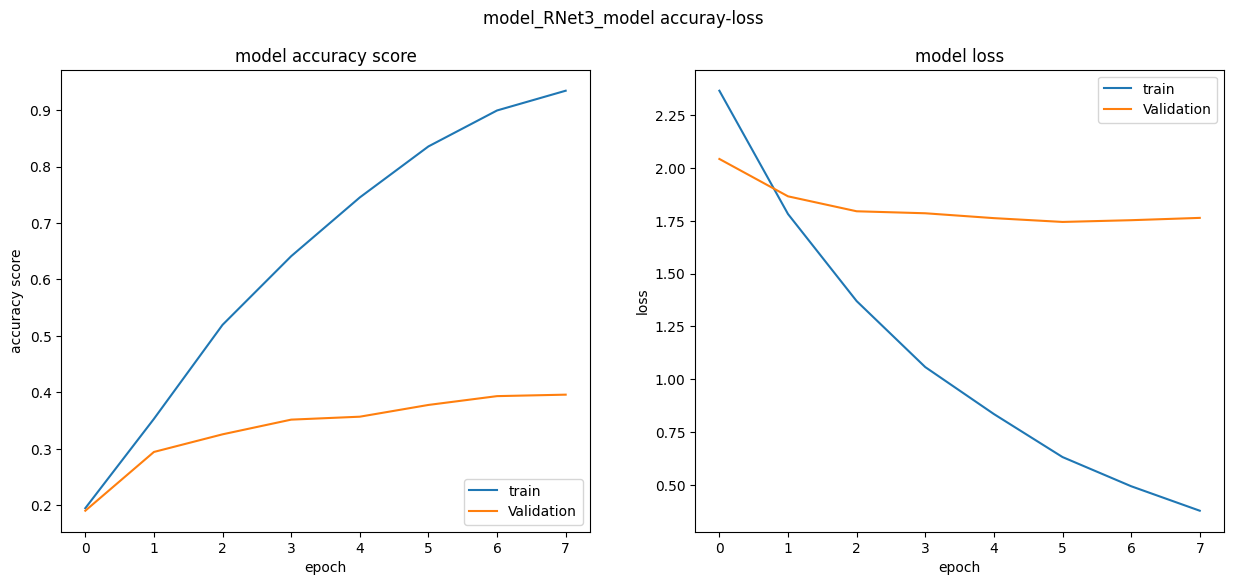

>> Model evaluation
13/13 [==============================] - 6s 424ms/step - loss: 1.7506 - accuracy: 0.4015
Loss: 1.751
Accuracy: 0.402
>> Model prediction
400/400 [==============================] - 8s 18ms/step

>> Metrics calculation


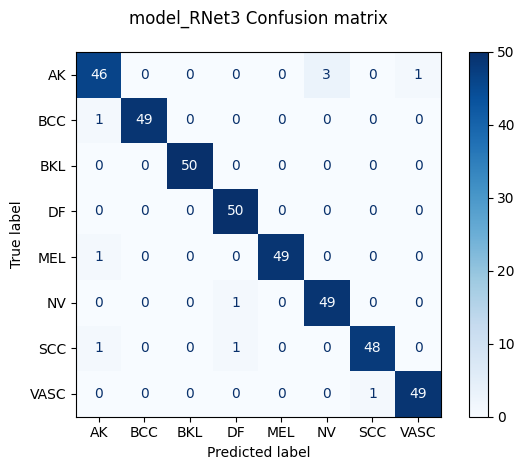

                 AK       BCC  BKL        DF       MEL        NV       SCC  \
precision  0.938776  1.000000  1.0  0.961538  1.000000  0.942308  0.979592   
sensibity  0.920000  0.980000  1.0  1.000000  0.980000  0.980000  0.960000   
f1 score   0.929293  0.989899  1.0  0.980392  0.989899  0.960784  0.969697   

           VASC  
precision  0.98  
sensibity  0.98  
f1 score   0.98  

Model Accuracy: 0.975
Model f1 score: 0.97
Model Precision: 0.98
Model Sensibity: 0.98


<Figure size 640x480 with 0 Axes>

In [49]:
results_model_management(modelRN3, modelRN3_history, valid_generator, test_generator, end_time )

In [50]:
# Save the model, weights & history to disc

saveModelParameters(model_path, modelRN3, modelRN3_history)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model parameters have been saved.
/content/drive/MyDrive/Colab Notebooks/Master UOC/TFM/Dermatological lesion classification/Data/Models/model_RNet3/model_RNet3


# 6 - Summary

In this last chapter, we will collect the training metrics of all the models and compare them in a table.

In addition, we will make a prediction with an image of each of the classes using the model that gave us the best metrics.

Finally, we will show a table with the prediction value for each of the classes.

## 6.1 Metrics table

In [16]:
# Añadir #params y # trainable params

models_name = list()
metrics_file = list()
rec = list()
n_train_params = list()
n_non_train_params = list()
n_epochs = list()

models_name = [
    'model_ENetB0_1',
    'model_ENetB0_2',
    'model_ENetB0_3',
    'model_RNet1',
    'model_RNet2',
    'model_RNet3'
]

metrics_file = [
                'model_ENetB0_1_metrics.pkl',
                'model_ENetB0_2_metrics.pkl',
                'model_ENetB0_3_metrics.pkl',
                'model_RNet1_metrics.pkl',
                'model_RNet2_metrics.pkl',
                'model_RNet3_metrics.pkl'
                ]

name_columns = ['Model name', 'ACC', 'SEN', 'ESP', 'F1-score', 'Time (sec)']
digits_round = 2
tbl_metrics_df = pd.DataFrame(columns=name_columns)


for m in models_name:
    #print(f'Model name: {m}')
    model = load_model(os.path.join(base_path, 'Models', m, m), compile = False)

    # We retrieve the trainable and not one paramameters

    non_trainable_count = count_params(model.non_trainable_weights)
    trainable_count = count_params(model.trainable_weights)

    n_non_train_params.append(non_trainable_count)
    n_train_params.append(trainable_count)

    # We retrieve the train epoch number parameter
    history = load_dict_from_disc(os.path.join(base_path, 'Models', m ,m + '_history.pkl'))
    n_epochs.append(len(history['loss']))

# We retrieve the model metrics
for f in metrics_file:
    metrics_df = load_dict_from_disc(os.path.join(metrics_path, f))

    rec = [metrics_df['model_name'],
        metrics_df['acc'],
        metrics_df['prec'].round(digits_round),
        metrics_df['recall'].round(digits_round),
        metrics_df['f1'].round(digits_round),
        round(metrics_df['Time'], digits_round) ]

    tbl_metrics_df.loc[len(tbl_metrics_df)] = rec

tbl_metrics_df['# Epochs'] = n_epochs
tbl_metrics_df['# Trainable params'] = n_train_params
tbl_metrics_df['# Total params'] = [a+b for a, b in zip(n_train_params, n_non_train_params)]

tbl_metrics_df

Model name     ACC   SEN   ESP  F1-score  Time (sec)  # Epochs  \
0  model_ENetB0_1  0.3950  0.45  0.40      0.39     3559.93        40   
1  model_ENetB0_2  0.4000  0.45  0.40      0.39      625.25         8   
2  model_ENetB0_3  0.5050  0.54  0.50      0.49     3243.97        40   
3     model_RNet1  0.3075  0.31  0.31      0.30     2266.10        30   
4     model_RNet2  0.8250  0.84  0.82      0.82      210.16         5   
5     model_RNet3  0.9750  0.98  0.98      0.97      496.95         8   

   # Trainable params  # Total params  
0               12808         4064939  
1             1361208         4064939  
2             4020356         4064939  
3               20488        23589384  
4            15250440        23589384  
5            23539848        23589384

## 6.2 Sample prediction

In [19]:

# Parameters
target_size = (224, 224)
batch_size = 32
color_mode = 'rgb'
seed = 1234
augmentation = False
scale = 2 # [-1, 1]

train_path = images_train_path
val_path = images_valid_path
test_path = images_test_path

_, _, test_generator = image_generator(
     train_path=train_path,
     val_path=val_path,
     test_path=test_path,
     target_size=target_size,
     batch_size=batch_size,
     color_mode=color_mode,
     seed=seed,
     augmentation=augmentation,
     scale=scale
     )

Generating pictures
Found 2400 images belonging to 8 classes.
Found 391 images belonging to 8 classes.
Found 400 images belonging to 8 classes.


In [20]:
#
model_name = 'model_RNet3'
model = load_model(os.path.join(base_path, 'Models', model_name, model_name))

labels = test_generator.labels
labels_idx = np.arange(8)
img_dict = dict()
pred_dict = dict()

for idx in labels_idx:
    for i in range(len(labels)):
        if labels[i] == idx:
            print(i, labels[i])
            img = test_generator[i]
            img_dict[labels[i]] =  img # Saving the image by label
            pred_dict[labels[i]] = model.predict(img) # Saving the image prediction by label
            break

0 0
1/1 [==============================] - 4s 4s/step
50 1
1/1 [==============================] - 0s 22ms/step
100 2
1/1 [==============================] - 0s 22ms/step
150 3
1/1 [==============================] - 0s 22ms/step
200 4
1/1 [==============================] - 0s 27ms/step
250 5
1/1 [==============================] - 0s 23ms/step
300 6
1/1 [==============================] - 0s 22ms/step
350 7
1/1 [==============================] - 0s 21ms/step


Text(0.5, 0.98, 'Sample images. Real vs Prediction (SMOTE version)')

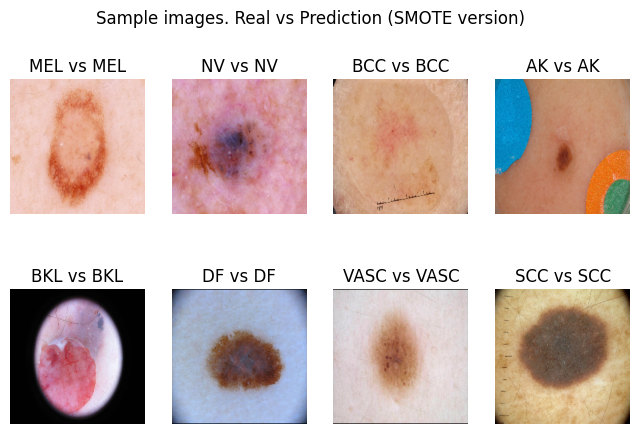

In [23]:
# Sample prediction of one image for each classe.
col = 0
row = 0

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(8,5))
for l, img in img_dict.items():
    img = img.reshape(224,224,3)
    norm_img = cv2.normalize(img, None, alpha = 0, beta = 1, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
    ax[row, col].imshow(norm_img)
    title = f'{return_label_from_index(l)} vs {return_label_from_index(np.argmax(pred_dict[l]))}'
    ax[row, col].set_title(title)
    ax[row, col].axis('off')
    if col < 3:
        col += 1
    else:
        col = 0
        row += 1

plt.suptitle('Sample images. Real vs Prediction (SMOTE version)')


In [22]:
# prediction Table. The predicions class by class are showed

columns_name = ['Class', 'MEL (%)', 'NV (%)', 'BCC (%)', 'AK (%)', 'BKL (%)', 'DF (%)', 'VASC (%)', 'SCC (%)']
table_pred = pd.DataFrame(columns=columns_name)


for l, v in pred_dict.items():
    rec = list()
    rec.append(return_label_from_index(l))
    for item in v.tolist()[0]:
        rec.append(np.round(item * 100, 2))
        # print(rec) # verbose mode
    table_pred.loc[len(table_pred)] = rec
table_pred

Class  MEL (%)  NV (%)  BCC (%)  AK (%)  BKL (%)  DF (%)  VASC (%)  SCC (%)
0   MEL    28.66    6.41     8.02   14.36     2.45   20.76      6.87    12.48
1    NV     2.19   55.19     3.28    4.98     1.96    4.72      3.93    23.75
2   BCC     0.20    0.35    94.69    0.76     0.61    1.33      1.14     0.92
3    AK     0.03    0.11     1.58   93.75     0.14    3.87      0.14     0.39
4   BKL     0.75    1.25     4.70    1.45    80.50    0.22      5.74     5.39
5    DF     0.11    0.68     0.06    0.06     0.91   97.80      0.18     0.20
6  VASC     5.49    2.63     8.27    7.84     3.18   20.57     49.58     2.44
7   SCC     0.72    0.92    10.57    4.44     9.95   11.38      4.53    57.49

# Notas

In [ ]:
# Convert python notebook into html file
%%shell
jupyter nbconvert --to html '/content/DermatologicalLesionClassification_v2.ipynb'

https://htmtopdf.herokuapp.com/ipynbviewer/